In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import crflux.models as pm
from MCEq.core import MCEqRun
from scipy.optimize import minimize_scalar
from collections import defaultdict

In [25]:
#MC_neutrinos_dir = "/groups/icecube/petersen/GraphNetDatabaseRepository/multi_classification_track_cascade_neutrino/using_new_muons_Peter_database/inference/track_cascade_sets/Monte_Carlo_all_events_all_variables.csv"
#
##Giant neutrino MC db
#db_MC_neutrinos = pd.read_csv(MC_neutrinos_dir)
#
#db_MC_neutrinos_cut = db_MC_neutrinos[(db_MC_neutrinos['energy'] > 1)                   #at least 50 GeV (start of data from paper)
#                                      & (db_MC_neutrinos['energy'] < 10000)             #at most 10 TeV
#                                      & (db_MC_neutrinos['interaction_type'] != -1)     #remove undefined interaction type
#                                      & (db_MC_neutrinos['interaction_type'] != 0)]      #remove non-interacting neutrinos
#                                      #& (abs(db_MC_neutrinos['pid']) != 16)]            #remove tau neutrinos

db_MC_neutrinos_cut = pd.read_csv('/groups/icecube/nielsdb/SinTheta_Aug2025/combined_ET_val_prediction_GNN_ET_MC_10M_231125_231125.csv')

In [26]:
# Verify the combined data structure
print("Data shape:", db_MC_neutrinos_cut.shape)
print("\nColumn names:")
print(db_MC_neutrinos_cut.columns.tolist())
print("\nFirst few rows:")
print(db_MC_neutrinos_cut.head())
print("\nData types:")
print(db_MC_neutrinos_cut.dtypes)
print("\nEnergy range:")
print(f"Min energy: {db_MC_neutrinos_cut['energy'].min()}")
print(f"Max energy: {db_MC_neutrinos_cut['energy'].max()}")
print("\nUnique interaction types:")
print(db_MC_neutrinos_cut['interaction_type'].unique())
print("\nValue counts for interaction_type:")
print(db_MC_neutrinos_cut['interaction_type'].value_counts())

Data shape: (4961152, 7)

Column names:
['event_no', 'pid', 'track_mu', 'energy', 'track_mu_pred', 'energy_pred', 'interaction_type']

First few rows:
   event_no  pid  track_mu     energy  track_mu_pred  energy_pred  \
0  14066347   16         0   2.704072       0.548561     4.109529   
1   3189492  -12         0  42.624892       0.488073    76.680428   
2  10709988   14         1   8.715674       0.515160    30.604748   
3  17213099  -14         1  53.853532       0.509538    23.741039   
4   3057902  -14         1   3.517444       0.513414     4.639201   

   interaction_type  
0                 2  
1                 1  
2                 1  
3                 1  
4                 1  

Data types:
event_no              int64
pid                   int64
track_mu              int64
energy              float64
track_mu_pred       float64
energy_pred         float64
interaction_type      int64
dtype: object

Energy range:
Min energy: 1.0000146409544732
Max energy: 9997.450733190375

Un

In [27]:
# Load flux from CSV file instead of computing it
flux_data = pd.read_csv('/groups/icecube/nielsdb/SinTheta_Aug2025/mceq_zenith_averaged_fluxes.csv')

# Check column names (in case of whitespace issues)
print("CSV columns:", flux_data.columns.tolist())

# Strip whitespace from column names
flux_data.columns = flux_data.columns.str.strip()

# Convert to the same format as the previous flux dictionary
flux = {
    'numu_total': flux_data['numu_total_flux'].values,
    'nue_total': flux_data['nue_total_flux'].values,
    'nutau_total': flux_data['nutau_total_flux'].values
}

# Use the energy grid from the CSV
log_bincenters = flux_data['Energy_GeV'].values

# Calculate bin edges for log spacing (same logic as before)
log_binedges = np.sqrt(log_bincenters[:-1] * log_bincenters[1:])
log_binedges = np.concatenate(([log_bincenters[0] * (log_bincenters[1]/log_bincenters[0])**-0.5], 
                               log_binedges, 
                               [log_bincenters[-1] * (log_bincenters[-1]/log_bincenters[-2])**0.5]))


CSV columns: ['Energy_GeV', 'numu_total_flux', 'nue_total_flux', 'nutau_total_flux']


In [28]:
energies = np.array([50, 100, 200, 500, 1000, 2000, 5000], dtype=float)
sigma_NC_ref = np.array([0.10, 0.20, 0.41, 1.0, 2.0, 3.8, 8.6]) * 1e-36
sigma_CC_ref = np.array([0.32, 0.65, 1.3, 3.2, 6.2, 12, 27]) * 1e-36 #from paper

nc_over_cc_target = np.ones(len(log_bincenters)) * 10.0 ** np.mean(np.log10(sigma_NC_ref / sigma_CC_ref))

print('Here we make a big assumption, we assume the NC/CC cross section ratio holds for all energies, and is the same for each flavour!!')


Here we make a big assumption, we assume the NC/CC cross section ratio holds for all energies, and is the same for each flavour!!


In [29]:
track_cut = 0.5  # threshold on 'track_mu_pred' to classify as track

# Allocate outputs per energy bin
n_bins = len(log_bincenters)
CC_w_flav_ccnc_list = np.zeros(n_bins, dtype=float)
NC_w_flav_ccnc_list = np.zeros(n_bins, dtype=float)
track_w_flav_ccnc_list = np.zeros(n_bins, dtype=float) 
casc_w_flav_ccnc_list = np.zeros(n_bins, dtype=float)  
track_pred_w_flav_ccnc_list = np.zeros(n_bins, dtype=float)
casc_pred_w_flav_ccnc_list = np.zeros(n_bins, dtype=float)

# Optional diagnostics
cc_rel = np.ones(n_bins, dtype=float)
nc_rel = np.ones(n_bins, dtype=float)

# Per-flavor totals
mu_hist_w = np.zeros(n_bins, dtype=float)
e_hist_w  = np.zeros(n_bins, dtype=float)
tau_hist_w = np.zeros(n_bins, dtype=float)

# Helper scaling function
def _scale_cc_nc_preserve_total(C1, N1, R):
    '''
    Function that computes scaling factors a and b to apply to CC and NC counts C1 and N1,
    respectively, such that the resulting counts C2 = a * C1 and N2 = b * N1 have the desired
    NC/CC ratio R, while preserving the total count T = C1 + N1.

    inputs:
    C1 (float): Initial count of charged-current events.
    N1 (float): Initial count of neutral-current events.
    R (float): Target NC/CC ratio.

    outputs:
    a (float): Scaling factor for charged-current events.
    b (float): Scaling factor for neutral-current events.
    C2 (float): Scaled count of charged-current events.
    N2 (float): Scaled count of neutral-current events.
    '''

    T = C1 + N1

    # Target split given ratio R = N/C => C = T/(1+R), N = T - C
    C_tgt = T / (1.0 + R)
    N_tgt = T - C_tgt
    a = (C_tgt / C1) if C1>0 else 0.0
    b = (N_tgt / N1) if N1>0 else 0.0
    return a, b, C_tgt, N_tgt

# Prepare container to collect per-bin DF rows during loop
df_rows = []

bin_edges = np.asarray(log_binedges, dtype=float)
bin_centers = np.asarray(log_bincenters, dtype=float)

# Pre-compute unweighted true counts per bin (once)
E_true_all = np.asarray(db_MC_neutrinos_cut['energy'].to_numpy(), dtype=float)
idx_true_all = np.digitize(E_true_all, bin_edges) - 1
N_events_true_full = np.bincount(idx_true_all[(idx_true_all>=0)&(idx_true_all < n_bins)], minlength=n_bins)[:n_bins]

for i in range(n_bins):
    # Flux fractions
    w_mu  = float(flux['numu_total'][i])
    w_e   = float(flux['nue_total'][i])
    w_tau = float(flux['nutau_total'][i])
    w_sum = w_mu + w_e + w_tau

    f_mu, f_e, f_tau = w_mu / w_sum, w_e / w_sum, w_tau / w_sum     #fractions expected

    # Events in bin
    db_in_bin = db_MC_neutrinos_cut[(db_MC_neutrinos_cut['energy'] > bin_edges[i]) &
                                    (db_MC_neutrinos_cut['energy'] <= bin_edges[i+1])]

    mu_mask  = (abs(db_in_bin['pid']) == 14)
    e_mask   = (abs(db_in_bin['pid']) == 12)
    tau_mask = (abs(db_in_bin['pid']) == 16)
    cc_mask  = (db_in_bin['interaction_type'] == 1)
    nc_mask  = (db_in_bin['interaction_type'] == 2)

    # Flavor counts (truth)
    N_mu = int(mu_mask.sum())
    N_e  = int(e_mask.sum())
    N_tau= int(tau_mask.sum())
    N_tot = N_mu + N_e + N_tau

    # Stage 1: flavor scaling to match flux fractions, preserving per-bin total N_tot
    # Desired per-flavor totals
    targ_mu = f_mu * N_tot
    targ_e  = f_e  * N_tot
    targ_tau= f_tau* N_tot

    s_mu  = (targ_mu / N_mu)  
    s_e   = (targ_e  / N_e)   
    #s_tau = (targ_tau/ N_tau) 

    # Split by CC/NC and flavor (raw counts)
    CC_mu   = int((cc_mask & mu_mask).sum())
    CC_e    = int((cc_mask & e_mask).sum())
    #CC_tau  = int((cc_mask & tau_mask).sum())
    NC_mu   = int((nc_mask & mu_mask).sum())
    NC_e    = int((nc_mask & e_mask).sum())
    #NC_tau  = int((nc_mask & tau_mask).sum())

    # Apply Stage 1 flavor scaling to CC/NC components
    C_mu1, N_mu1   = s_mu * CC_mu,  s_mu * NC_mu
    C_e1,  N_e1    = s_e  * CC_e,   s_e  * NC_e
    #C_tau1, N_tau1 = s_tau* CC_tau, s_tau* NC_tau

    R_bin = float(nc_over_cc_target[i])
    a_mu,  b_mu,  C_mu2,  N_mu2  = _scale_cc_nc_preserve_total(C_mu1,  N_mu1,  R_bin)
    a_e,   b_e,   C_e2,   N_e2   = _scale_cc_nc_preserve_total(C_e1,   N_e1,   R_bin)
    # Tau excluded intentionally if sparse:
    # a_tau, b_tau, C_tau2, N_tau2 = _scale_cc_nc_preserve_total(C_tau1, N_tau1, R_bin)

    # Totals after flavor+interaction reweighting
    CC_total_w = C_mu2 + C_e2  # + C_tau2 if enabled
    NC_total_w = N_mu2 + N_e2  # + N_tau2 if enabled

    CC_w_flav_ccnc_list[i] = CC_total_w
    NC_w_flav_ccnc_list[i] = NC_total_w

    C_sum1 = C_mu1 + C_e1 #+ C_tau1
    N_sum1 = N_mu1 + N_e1 #+ N_tau1
    cc_rel[i] = (CC_total_w / C_sum1) if C_sum1>0 else 1.0
    nc_rel[i] = (NC_total_w / N_sum1) if N_sum1>0 else 1.0

    mu_hist_w[i]  = C_mu2  + N_mu2
    e_hist_w[i]   = C_e2   + N_e2
    # tau_hist_w[i] left zero

    # Per-bin NC/CC ratio (after weighting)
    nc_over_cc_val = (NC_total_w / CC_total_w) if CC_total_w > 0 else np.nan

    # Weighted track and cascade counts using predicted thresholding or truth
    # Build per-event weights aligned with flavor+interaction weighting above:
    #   w_cc_mu = s_mu * a_mu, w_nc_mu = s_mu * b_mu, etc.
    w_cc_mu = s_mu * a_mu
    w_nc_mu = s_mu * b_mu
    w_cc_e  = s_e  * a_e
    w_nc_e  = s_e  * b_e
    # w_tau weights omitted (0)

    # Per-event vectorized weights in this energy bin
    w_events = np.zeros(len(db_in_bin), dtype=float)
    # muon
    w_events[mu_mask & cc_mask] = w_cc_mu
    w_events[mu_mask & nc_mask] = w_nc_mu
    # electron
    w_events[e_mask & cc_mask]  = w_cc_e
    w_events[e_mask & nc_mask]  = w_nc_e

    # Truth-based track/cascade using track_mu
    is_track_true = (np.asarray(db_in_bin['track_mu'], dtype=float) > 0.5)
    track_w = float(np.sum(w_events[is_track_true]))
    casc_w  = float(np.sum(w_events[~is_track_true]))

    track_w_flav_ccnc_list[i] = track_w
    casc_w_flav_ccnc_list[i]  = casc_w
    track_over_casc_val = (track_w / casc_w) if casc_w>0 else np.nan

    # Predicted-based track/cascade using track_mu_pred
    is_track_pred = (np.asarray(db_in_bin['track_mu_pred'], dtype=float) > 0.5)
    track_w_pred = float(np.sum(w_events[is_track_pred]))
    casc_w_pred  = float(np.sum(w_events[~is_track_pred]))
    track_pred_w_flav_ccnc_list[i] = track_w_pred
    casc_pred_w_flav_ccnc_list[i]  = casc_w_pred
    track_over_casc_pred = (track_w_pred / casc_w_pred) if casc_w_pred>0 else np.nan

    # Append row immediately
    df_rows.append({
        'E_low': float(bin_edges[i]),
        'E_high': float(bin_edges[i+1]),
        'E_center': float(bin_centers[i]),
        'N_events_true': int(N_events_true_full[i]),
        'w_mu_cc': float(w_cc_mu),
        'w_mu_nc': float(w_nc_mu),
        'w_e_cc': float(w_cc_e),
        'w_e_nc': float(w_nc_e),
        'w_tau_cc': float(0),
        'w_tau_nc': float(0),
        'mu_cc_total_weighted': float(C_mu2),
        'mu_nc_total_weighted': float(N_mu2),
        'e_cc_total_weighted': float(C_e2),
        'e_nc_total_weighted': float(N_e2),
        'tau_cc_total_weighted': float(0),
        'tau_nc_total_weighted': float(0),
        'nc_over_cc': float(nc_over_cc_val) if np.isfinite(nc_over_cc_val) else np.nan,
        'track_total_weighted': float(track_w) if np.isfinite(track_w) else np.nan,
        'cascade_total_weighted': float(casc_w) if np.isfinite(casc_w) else np.nan,
        'track_pred_total_weighted': float(track_w_pred) if np.isfinite(track_w_pred) else np.nan,
        'cascade_pred_total_weighted': float(casc_w_pred) if np.isfinite(casc_w_pred) else np.nan,
        'track_over_cascade': float(track_over_casc_val) if np.isfinite(track_over_casc_val) else np.nan,
        'track_over_cascade_pred': float(track_over_casc_pred) if np.isfinite(track_over_casc_pred) else np.nan,
    })

# Build DataFrame after loop
bin_summary_df = pd.DataFrame(df_rows)
print(f"[BIN DF] Created bin_summary_df with shape {bin_summary_df.shape} and columns: {list(bin_summary_df.columns)}")
display(bin_summary_df.head())

[BIN DF] Created bin_summary_df with shape (40, 23) and columns: ['E_low', 'E_high', 'E_center', 'N_events_true', 'w_mu_cc', 'w_mu_nc', 'w_e_cc', 'w_e_nc', 'w_tau_cc', 'w_tau_nc', 'mu_cc_total_weighted', 'mu_nc_total_weighted', 'e_cc_total_weighted', 'e_nc_total_weighted', 'tau_cc_total_weighted', 'tau_nc_total_weighted', 'nc_over_cc', 'track_total_weighted', 'cascade_total_weighted', 'track_pred_total_weighted', 'cascade_pred_total_weighted', 'track_over_cascade', 'track_over_cascade_pred']


,E_low,E_high,E_center,N_events_true,w_mu_cc,w_mu_nc,w_e_cc,w_e_nc,w_tau_cc,w_tau_nc,...,e_nc_total_weighted,tau_cc_total_weighted,tau_nc_total_weighted,nc_over_cc,track_total_weighted,cascade_total_weighted,track_pred_total_weighted,cascade_pred_total_weighted,track_over_cascade,track_over_cascade_pred
0,1.000000,1.258925,1.122018,25516,0.896296,8.363589,0.724964,8.499631,0.0,0.0,...,2031.411751,0.0,0.0,0.315089,12953.265417,12559.947957,9703.292256,15809.921119,1.031315,0.613747
1,1.258925,1.584893,1.412538,36091,0.849481,8.431166,0.790873,8.920417,0.0,0.0,...,2854.533402,0.0,0.0,0.315089,18382.777752,17706.195780,14653.110655,21435.862877,1.038212,0.683579
2,1.584893,1.995262,1.778279,49883,0.816719,9.421686,0.833687,10.060387,0.0,0.0,...,3913.490355,0.0,0.0,0.315089,25506.123681,24370.459280,21964.490120,27912.092841,1.046600,0.786917
3,1.995262,2.511886,2.238721,67032,0.809883,9.201995,0.857049,9.254881,0.0,0.0,...,5182.733398,0.0,0.0,0.315089,34519.639780,32507.967024,30782.822878,36244.783926,1.061882,0.849304
4,2.511886,3.162278,2.818383,85875,0.809103,8.389286,0.877323,8.922892,0.0,0.0,...,6504.788150,0.0,0.0,0.315089,44650.349524,41217.910763,41522.709998,44345.550289,1.083275,0.936344


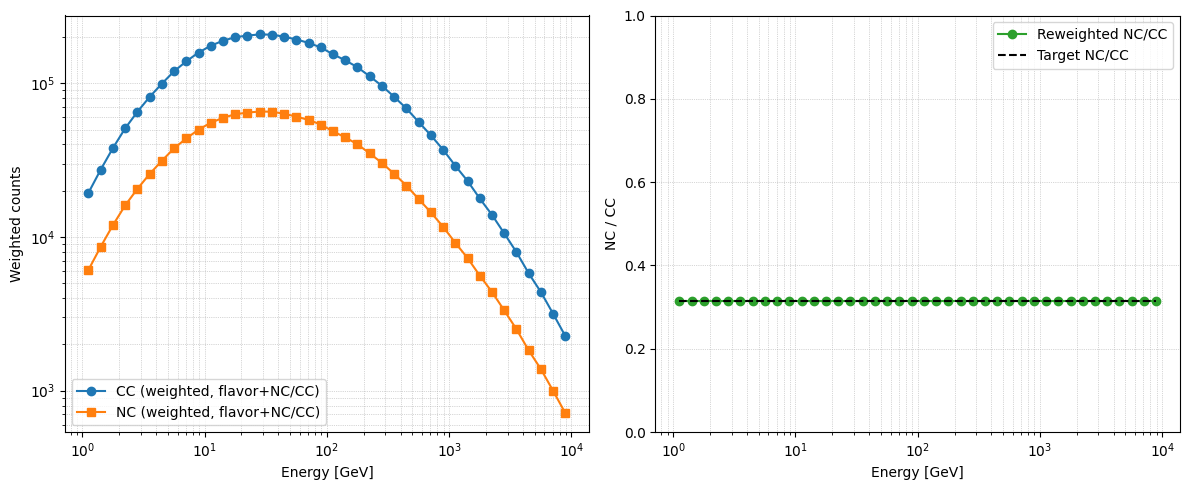

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: weighted CC and NC per energy bin (after flavor + CC/NC reweighting)
axes[0].plot(bin_summary_df['E_center'], bin_summary_df['mu_cc_total_weighted']+bin_summary_df['e_cc_total_weighted']+bin_summary_df['tau_cc_total_weighted'], marker='o', label='CC (weighted, flavor+NC/CC)')
axes[0].plot(bin_summary_df['E_center'], bin_summary_df['mu_nc_total_weighted']+bin_summary_df['e_nc_total_weighted']+bin_summary_df['tau_nc_total_weighted'], marker='s', label='NC (weighted, flavor+NC/CC)')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel('Energy [GeV]')
axes[0].set_ylabel('Weighted counts')
axes[0].legend()
axes[0].grid(True, which='both', ls=':', lw=0.5)

# Right: NC/CC ratio after reweighting
cc = bin_summary_df['mu_cc_total_weighted']+bin_summary_df['e_cc_total_weighted']+bin_summary_df['tau_cc_total_weighted']
nc = bin_summary_df['mu_nc_total_weighted']+bin_summary_df['e_nc_total_weighted']+bin_summary_df['tau_nc_total_weighted']
ncovercc = np.divide(nc, cc, out=np.full_like(cc, np.nan), where=(cc > 0))

axes[1].plot(log_bincenters, ncovercc, marker='o', color='C2', label='Reweighted NC/CC')
axes[1].set_xscale('log')
axes[1].set_xlabel('Energy [GeV]')
axes[1].set_ylabel('NC / CC')
axes[1].grid(True, which='both', ls=':', lw=0.5)

# Optional: overlay target NC/CC if provided
overlay = np.asarray(nc_over_cc_target, dtype=float)
axes[1].plot(log_bincenters, overlay, color='k', linestyle='--', label='Target NC/CC')

axes[1].legend()

# Dynamic y-limit to accommodate ratios that may exceed 1
ymax = np.nanmax(ncovercc) if np.all(np.isfinite(ncovercc)) else np.nanmax(np.where(np.isfinite(ncovercc), ncovercc, np.nan))
if overlay is not None:
    try:
        ymax = np.nanmax([ymax, np.nanmax(overlay)])
    except Exception:
        pass
if np.isfinite(ymax):
    axes[1].set_ylim(0, max(1.0, 1.2 * ymax))

plt.tight_layout()
plt.show()


In [31]:

# Define quark list and their (I3, Q) values
_quarks = {
    'u': {'I3':  0.5, 'Q':  2/3},
    'c': {'I3':  0.5, 'Q':  2/3},
    'd': {'I3': -0.5, 'Q': -1/3},
    's': {'I3': -0.5, 'Q': -1/3},
    'b': {'I3': -0.5, 'Q': -1/3},
    # top quark not included (threshold very high, negligible PDF in nucleon at relevant x)
}

def gL_gR_for_quark(q, sin2w):
    """Return (gL, gR) for quark q given sin^2(theta_W)."""
    I3 = _quarks[q]['I3']
    Q  = _quarks[q]['Q']
    gL = I3 - Q * sin2w
    gR = - Q * sin2w
    return gL, gR

def coupling_squared_sum(sin2w):
    """
    Compute S(sin2w) =  (gL^2 + gR^2)
    If weights is None, use equal weights for each quark in _quarks.
    weights should be a dict mapping quark->weight (nonnegative).
    """
    S = 0.0
    for q in _quarks.keys():
        gL, gR = gL_gR_for_quark(q, sin2w)
        S += (gL**2 + gR**2)
    return S

def R_of_sin2w(sin2w, sin2w_ref=0.23126):
    """
    Return scaling factor R(sin2w) = S(sin2w) / S(sin2w_ref)
    where S = sum_q w_q (gL^2 + gR^2).
    """
    S_ref = coupling_squared_sum(sin2w_ref)
    S = coupling_squared_sum(sin2w)
    return S / S_ref

def scale_sigma_NC(sigma_NC_ref, sin2w, sin2w_ref=0.2229):
    """
    Scale a reference sigma_NC (scalar or numpy array) by R(sin2w).
    Returns scaled sigma_NC for same shape as sigma_NC_ref.
    """
    R = R_of_sin2w(sin2w, sin2w_ref=sin2w_ref)
    return np.array(sigma_NC_ref) * float(R), float(R)

#0.2229 from standard model 1- (Mw)/(Mz)^2 

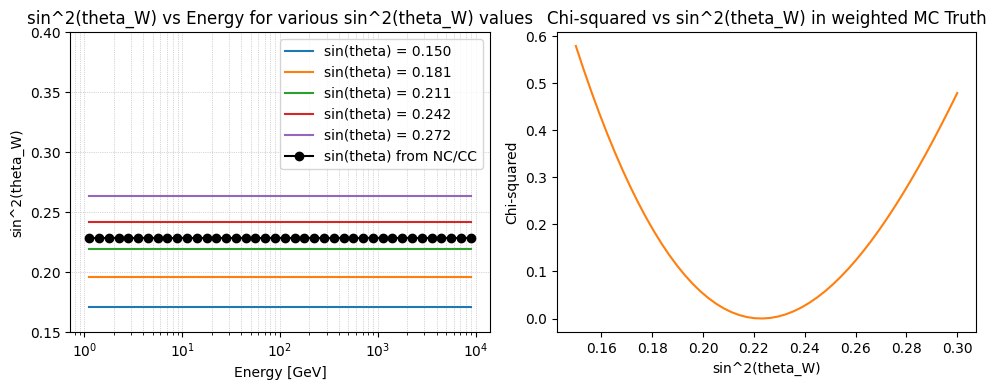

This is "proof" that scaling of NC due to changes in sin2theta correctly works in MC truth
Keep in mind, paper is imperfect


In [32]:
# Invert R = 1/2 - sin^2(theta) + (5/9)*1.5 sin^4(theta) per energy, using R = NC/CC, then plot sin(theta) vs energy
def get_nccc_from_tc(R, alpha=(flux['numu_total']/(flux['nue_total']+flux['numu_total']))):
    #important, no taus included, we exclude them in weighing, so also here, if not there is a slight uptic at the end of the energy scale...

    '''get the nc over cc ration from the track over cascade ratio, 
    ASSUMING we know that track over cascade = muon cc over (e cc + tau cc + nc all flavours) and assuming alpha
    '''
    return alpha/R + alpha - 1


def get_s2t_from_nccc(R):
    # Polynomial: R = 1/2 - s + (5/9) s^2 (1+r) with s = sin^2(theta), r=0.5
    # Rearranged: (5/9) s^2 - s + (1/2 - R) = 0
    a = 7.5/9.0
    b = -1.0
    c = 0.50-R
    disc = b*b - 4*a*c  
    # Guard unphysical/negative discriminant
    if not np.isfinite(disc) or np.any(disc < 0):
        # If vector-like input sneaks in, handle elementwise via list comprehension outside
        if np.isscalar(R):
            return np.nan
        # For arrays, caller should map elementwise; keep NaN-safe return
        return np.nan
    # Roots for s
    sqrt_disc = np.sqrt(disc)
    s1 = (-b - sqrt_disc) / (2*a)
    s2 = (-b + sqrt_disc) / (2*a)

    # Choose physically meaningful root in [0,1]
    if 0.0 <= s1 <= 1.0:
        return s1
    elif 0.0 <= s2 <= 1.0:
        return s2
    else:
        return np.nan
# Compute R = NC/CC per bin

cc = bin_summary_df['mu_cc_total_weighted']+bin_summary_df['e_cc_total_weighted']+bin_summary_df['tau_cc_total_weighted']
nc = bin_summary_df['mu_nc_total_weighted']+bin_summary_df['e_nc_total_weighted']+bin_summary_df['tau_nc_total_weighted']
ncovercc = np.divide(nc, cc, out=np.full_like(cc, np.nan), where=(cc > 0))

sin_theta = np.array([get_s2t_from_nccc(r) for r in ncovercc])

sin2w_values = np.linspace(0.15, 0.3, 50)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

chi2res = []
results = []
i=0
for s in sin2w_values:
    NC_scaled, R = scale_sigma_NC(nc, s)
    st = np.array([get_s2t_from_nccc(r) for r in np.divide(NC_scaled, cc)])
    chi2 = np.nansum((st - sin_theta)**2/sin_theta)
    chi2res.append(chi2)

    if i % 10 == 0:
        ax[0].plot(log_bincenters, st, label=f'sin(theta) = {s:.3f}')
    i += 1


ax[0].plot(log_bincenters, sin_theta, marker='o', color='black', label='sin(theta) from NC/CC')
ax[0].set_xscale('log')
ax[0].set_xlabel('Energy [GeV]')
ax[0].set_ylabel('sin^2(theta_W)')
ax[0].set_ylim(0.15, 0.4)
ax[0].grid(True, which='both', ls=':', lw=0.5)
ax[0].legend()
ax[0].set_title('sin^2(theta_W) vs Energy for various sin^2(theta_W) values')

ax[1].plot(sin2w_values, chi2res, color='tab:orange')
ax[1].set_xlabel('sin^2(theta_W)')
ax[1].set_ylabel('Chi-squared')
ax[1].set_title('Chi-squared vs sin^2(theta_W) in weighted MC Truth')

plt.tight_layout()
plt.show()

print('This is "proof" that scaling of NC due to changes in sin2theta correctly works in MC truth')
print('Keep in mind, paper is imperfect')

track/cascade -> nc/cc -> sinetheta works!


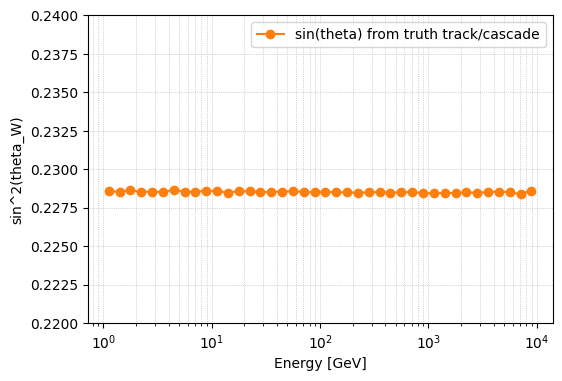

In [33]:
ncover_cc = get_nccc_from_tc(bin_summary_df['track_over_cascade'])
sin_theta_data = np.array([get_s2t_from_nccc(r) for r in ncover_cc])
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(log_bincenters, sin_theta_data, marker='o', color='tab:orange',
        label='sin(theta) from truth track/cascade')
ax.set_xscale('log')
ax.set_xlabel('Energy [GeV]')
ax.set_ylabel('sin^2(theta_W)')
ax.set_ylim(0.22, 0.24)
ax.grid(True, which='both', ls=':', lw=0.5)
ax.legend()

print('track/cascade -> nc/cc -> sinetheta works!')

In [34]:
# Updated resampling to use weights from bin_summary_df (w_* columns) and apply NC scaling R
# Changes:
# - Base per-event weight derived from bin_summary_df: depending on flavor (pid) and interaction (CC/NC)
# - APPLY R SCALING PER ENERGY BIN (combining all track bins):
#     For each true energy bin, multiply NC weights by R and scale CC by 'a' so the ENERGY-BIN total weight is conserved.
#     The same (a, R) applies to all track bins within that energy bin.
# - Uniform peer sampling of predicted values within (Ebin, trackbin) groups; accumulation uses final per-event weights.
# - With resample_E=False or resample_T=False, the corresponding variable is NOT permuted and stays as truth.


def resample_predictions_per_true_bin_optimized(
    data,
    df,
    R=1.0,
    resample_E=True,
    resample_T=True,
    n_energy_bins=40,
    n_track_bins=40,
    return_events=True,
):
    """
    Resample event-level predictions within truth bins while reweighting CC/NC to enforce a
    desired NC amplification factor R, conserving the TOTAL WEIGHT PER TRUE ENERGY BIN (not per track bin).

    Parameters
    - data: pandas.DataFrame
        Must contain columns: 'energy', 'energy_pred', 'track_mu', 'track_mu_pred', 'pid', 'interaction_type'.
        - energy: true energy (float)
        - energy_pred: predicted energy (float); only used if resample_E=True
        - track_mu: true track score in [0,1]
        - track_mu_pred: predicted track score in [0,1]; only used if resample_T=True
        - pid: PDG code; |pid|==14(mu),12(e),16(tau)
        - interaction_type: 1=CC, 2=NC
    - df: pandas.DataFrame
        Per-energy-bin weights and edges, with columns:
        ['E_low','E_high','w_mu_cc','w_mu_nc','w_e_cc','w_e_nc', optionally 'w_tau_cc','w_tau_nc'].
        Weights are interpreted as BASE weights per energy bin for the given flavor+interaction.
    - R: float
        NC weight amplification factor applied UNIFORMLY to all NC events in the same true energy bin.
        CC is downscaled by a factor 'a' so the energy-bin total weight is conserved.
    - resample_E: bool
        If True, energy values are permuted within each (energy, track) group using peers' energy_pred.
        If False, energies remain the true values (no permutation).
    - resample_T: bool
        If True, track values are permuted within each (energy, track) group using peers' track_mu_pred.
        If False, tracks remain the true values (no permutation).
    - n_energy_bins: int
        Number of bins for the energy histogram output (uses df edges).
    - n_track_bins: int
        Number of track bins in [0,1] used to define groups and histogram edges.
    - return_events: bool (default True)
        If True, include 'events' and 'event_weights' in the returned dictionary for downstream analyses.

    Returns
    - result: dict with keys
        'hist_weights'  -> 2D weighted histogram over (energy_edges, track_edges)
        'energy_edges'  -> 1D array of energy bin edges (aligned with df)
        'track_edges'   -> 1D array of track bin edges in [0,1]
        'energy_centers'-> geometric centers of energy bins
        'track_centers' -> centers of track bins
        'diagnostics'   -> list of per-energy-bin diagnostic dicts (scales used)
        if return_events:
            'events'         -> {'energy': e_vals, 'track': t_vals}
            'event_weights'  -> per-event final weights after CC/NC balancing

    Notes
    - Internally, per-event BASE weights are assigned from df using (energy bin, flavor, interaction_type),
      then modified at the ENERGY-BIN level to apply R to NC and 'a' to CC so that the total energy-bin weight is conserved.
    """

    # Extract event-level arrays from input DataFrame
    e_true = data['energy'].to_numpy(dtype=float)
    e_pred = data['energy_pred'].to_numpy(dtype=float)
    t_true = data['track_mu'].to_numpy(dtype=float)
    t_pred = data['track_mu_pred'].to_numpy(dtype=float)
    pid    = data['pid'].to_numpy()
    itype  = data['interaction_type'].to_numpy()

    # Build energy edges from df so that binning used for weight lookup exactly matches df
    df_edges = np.unique(np.concatenate([df['E_low'].to_numpy(dtype=float), df['E_high'].to_numpy(dtype=float)]))
    df_edges.sort()
    # Use df edges for energy histogram alignment; track is always in [0,1]
    energy_edges = df_edges.copy()
    track_edges = np.linspace(0.0, 1.0, n_track_bins + 1)

    # Map each event's TRUE energy to the df's energy bin index
    ebin_df = np.digitize(e_true, energy_edges) - 1
    ebin_df = np.clip(ebin_df, 0, len(energy_edges) - 2)

    # Pull BASE weights (before applying R) from df for each energy bin and flavor+interaction
    w_mu_cc = df['w_mu_cc'].to_numpy(dtype=float)
    w_mu_nc = df['w_mu_nc'].to_numpy(dtype=float)
    w_e_cc  = df['w_e_cc'].to_numpy(dtype=float)
    w_e_nc  = df['w_e_nc'].to_numpy(dtype=float)
    w_tau_cc = df['w_tau_cc'].to_numpy(dtype=float) if 'w_tau_cc' in df.columns else np.zeros_like(w_mu_cc)
    w_tau_nc = df['w_tau_nc'].to_numpy(dtype=float) if 'w_tau_nc' in df.columns else np.zeros_like(w_mu_nc)

    # Flavor masks: absolute PDG codes (mu=14, e=12, tau=16)
    mu_mask = (np.abs(pid) == 14)
    e_mask  = (np.abs(pid) == 12)
    tau_mask= (np.abs(pid) == 16)
    # Interaction masks: 1=CC, 2=NC
    cc_mask = (itype == 1)
    nc_mask = (itype == 2)

    # Assign BASE per-event weights from df, depending on flavor and interaction
    # Note: all events in the same energy bin with the same (flavor, interaction) get the same base weight
    base_cc = np.where(mu_mask, w_mu_cc[ebin_df],
              np.where(e_mask,  w_e_cc[ebin_df],
              np.where(tau_mask, w_tau_cc[ebin_df], 0.0)))
    base_nc = np.where(mu_mask, w_mu_nc[ebin_df],
              np.where(e_mask,  w_e_nc[ebin_df],
              np.where(tau_mask, w_tau_nc[ebin_df], 0.0)))
    base_weight = np.where(cc_mask, base_cc, base_nc)

    # PER-ENERGY-BIN CC/NC SCALING: compute a (for CC) so that
    #   sum_CC(a*w_cc) + sum_NC(R*w_nc) == sum_total(base)
    # and apply uniformly across all track bins within that energy bin.
    w_vals = np.empty_like(base_weight, dtype=float)
    diagnostics = []
    R = float(R) if np.isfinite(R) else 1.0

    n_e_bins_df = len(energy_edges) - 1
    for eb in range(n_e_bins_df):
        sel_e = (ebin_df == eb)
        if not np.any(sel_e):
            continue
        cc_sel = sel_e & cc_mask
        nc_sel = sel_e & nc_mask
        sum_cc_orig = float(np.sum(base_weight[cc_sel]))
        sum_nc_orig = float(np.sum(base_weight[nc_sel]))
        total_orig  = sum_cc_orig + sum_nc_orig

        if (sum_cc_orig > 0.0) and (sum_nc_orig > 0.0):
            sum_nc_scaled = sum_nc_orig * R
            a = (total_orig - sum_nc_scaled) / sum_cc_orig if sum_cc_orig > 0 else 0.0
            if a < 0.0:
                # Clamp and renormalize to preserve the energy-bin total
                a_eff = 0.0
                w_temp_sum = sum_nc_scaled  # CC contributes zero in this extreme case
                scale = (total_orig / w_temp_sum) if w_temp_sum > 0 else 1.0
                f_cc = 0.0
                f_nc = R * scale
            else:
                a_eff = a
                f_cc = a_eff
                f_nc = R
        else:
            # Degenerate cases: only CC or only NC or empty -> keep base weights
            a_eff = np.nan if (sum_cc_orig == 0.0 and sum_nc_orig > 0.0) else 1.0
            f_cc = 1.0
            f_nc = 1.0

        # Apply factors within this energy bin uniformly across all track bins
        w_vals[nc_sel] = base_weight[nc_sel] * f_nc
        w_vals[cc_sel] = base_weight[cc_sel] * f_cc

        diagnostics.append({
            'energy_bin': int(eb),
            'sum_cc_orig': sum_cc_orig,
            'sum_nc_orig': sum_nc_orig,
            'total_orig': total_orig,
            'R_used': R,
            'a_cc': float(a_eff) if np.isfinite(a_eff) else a_eff,
            'f_cc': float(f_cc),
            'f_nc': float(f_nc),
        })

    # Define GROUPS by (true energy bin, true track bin) ONLY for peer permutations
    tbin_group = np.digitize(t_true, track_edges) - 1
    tbin_group = np.clip(tbin_group, 0, n_track_bins - 1)
    group_id = ebin_df * n_track_bins + tbin_group

    # Output arrays for (possibly resampled) energy/track
    e_vals = np.empty_like(e_true, dtype=float)
    t_vals = np.empty_like(t_true, dtype=float)

    # Sort indices by group_id so we can process one contiguous chunk per unique group
    idx_sorted = np.argsort(group_id)
    gid_sorted = group_id[idx_sorted]
    unique_gids, start_idx, counts = np.unique(gid_sorted, return_index=True, return_counts=True)

    rng = np.random.default_rng()

    # Main loop: process each (true E bin, true track bin) group for resampling only
    for gid, start, cnt in zip(unique_gids, start_idx, counts):
        inds = idx_sorted[start:start+cnt]
        # Within the group, choose a random peer index for permutation (if resampling is enabled)
        peer_choice = rng.integers(0, cnt, size=cnt)
        peer_idx = inds[peer_choice]

        # Apply resampling toggles
        if resample_E:
            # Energy comes from a random peer's predicted energy
            e_vals[inds] = e_pred[peer_idx]
        else:
            # No resampling: keep the true energy
            e_vals[inds] = e_true[inds]
            
        if resample_T:
            # Track comes from a random peer's predicted track score
            t_vals[inds] = t_pred[peer_idx]
        else:
            # No resampling: keep the true track score
            t_vals[inds] = t_true[inds]

    # Build a weighted 2D histogram of the (possibly resampled) values
    H, _, _ = np.histogram2d(e_vals, t_vals, bins=[energy_edges, track_edges], weights=w_vals)

    # Assemble result dictionary
    result = {
        'hist_weights': H,
        'energy_edges': energy_edges,
        'track_edges': track_edges,
        'energy_centers': np.sqrt(energy_edges[:-1] * energy_edges[1:]),
        'track_centers': 0.5 * (track_edges[:-1] + track_edges[1:]),
        'diagnostics': diagnostics,
    }
    if return_events:
        result['events'] = {'energy': e_vals, 'track': t_vals}
        result['event_weights'] = w_vals

    return result


In [35]:
# Reconstructed sin^2(theta_W) vs energy using weighted resampler per user spec
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def reconstruct_sin2_from_predictions(
    sin2w_values,
    resample_E=True,
    resample_T=True,
    n_energy_bins=40,
    n_track_bins=40,
):
    """
    For each sin^2(theta_W) hypothesis:
      1) Compute R scale for NC (relative NC amplification factor).
      2) Run weighted resampler (NC weight = R, CC scaled down per truth bin to conserve total).
      3) Bin events by (possibly resampled) energy; compute track fraction using WEIGHTED statistics:
      4) Convert track/cascade ratio -> NC/CC via get_nccc_from_tc(alpha(E)).
      5) Invert NC/CC -> sin^2(theta_W).
    Returns DataFrame with columns: sin2w_hypo, E_center, sin2w_reco.
    """
    E_flux = np.asarray(log_bincenters, dtype=float)
    alpha_flux = (flux['numu_total']) / (flux['nue_total'] + flux['numu_total']) #no tau
    alpha_flux = np.asarray(alpha_flux, dtype=float)

    rows = []
    for s in sin2w_values:
        _, R_scale = scale_sigma_NC(np.array([1.0]), s)
        print(R_scale)
        res = resample_predictions_per_true_bin_optimized(
            db_MC_neutrinos_cut, bin_summary_df, R=R_scale,
            resample_E=resample_E, resample_T=resample_T,
            n_energy_bins=n_energy_bins, n_track_bins=n_track_bins,
            return_events=True
        )
        e_edges = res['energy_edges']
        e_centers = res['energy_centers']
        tracks = res['events']['track']
        w_events = res['event_weights']
        energies = res['events']['energy']
        ebin = np.digitize(energies, e_edges) - 1
        for i in range(len(e_centers)):
            sel = (ebin == i)

            tvals = tracks[sel]
            wvals = w_events[sel]
            wsum = np.sum(wvals)

            is_track = (tvals > 0.5)
            n_t = float(np.sum(wvals[is_track]))
            n_c = float(np.sum(wvals[~is_track]))
            tc = (n_t / n_c) if n_c > 0 else np.nan

            alpha_i = float(np.interp(np.log10(e_centers[i]), np.log10(E_flux), alpha_flux, left=alpha_flux[0], right=alpha_flux[-1]))
            nccc = get_nccc_from_tc(tc, alpha=alpha_i)
            s2 = get_s2t_from_nccc(nccc)
            rows.append({'sin2w_hypo': float(s), 'E_center': float(e_centers[i]), 'sin2w_reco': float(s2) if np.isfinite(s2) else np.nan})
    return pd.DataFrame(rows)

sin2w_grid = [0.1, 0.222, 0.3]
df_reco = reconstruct_sin2_from_predictions(sin2w_grid, resample_E=False, resample_T=False, n_energy_bins=40, n_track_bins=40)
print(f"Reconstructed DF shape (weighted): {df_reco.shape}")


1.2228932369229888


1.001316989455275
0.904445051427568
Reconstructed DF shape (weighted): (120, 3)


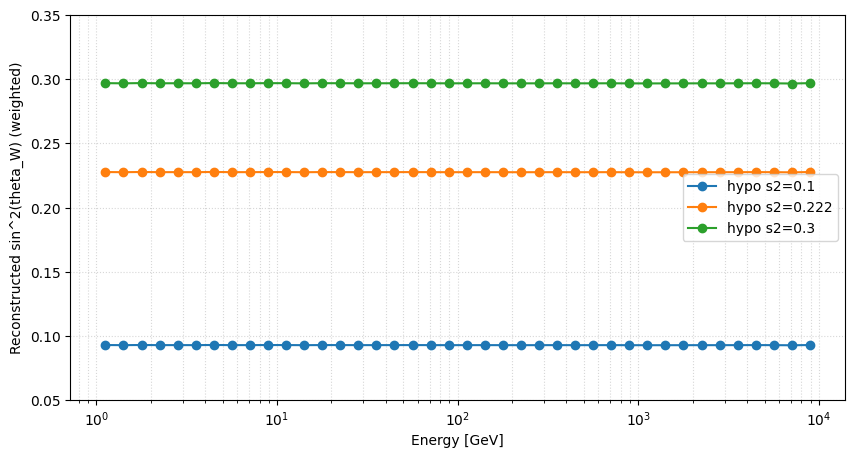

Scaling due to sin2theta change works for MC truth in resampling function, but not perfectly! This is due to many approximations made along the way, but difference is small


In [36]:
fig, ax = plt.subplots(figsize=(10,5))
for s in sin2w_grid:
    sub = df_reco[df_reco['sin2w_hypo']==s].sort_values('E_center')
    ax.plot(sub['E_center'], sub['sin2w_reco'], marker='o', label=f'hypo s2={s}')
ax.set_ylim(0.05, 0.35)
ax.set_xscale('log')
ax.set_xlabel('Energy [GeV]')
ax.set_ylabel('Reconstructed sin^2(theta_W) (weighted)')
ax.grid(True, which='both', ls=':', alpha=0.5)
ax.legend()
plt.show()

print('Scaling due to sin2theta change works for MC truth in resampling function, but not perfectly! This is due to many approximations made along the way, but difference is small')

In [37]:
# 4x2 grid: rows = four modes, cols = [track/cascade, derived sin^2(theta_W)]
# Each subplot shows curves for all sin2w values in sin2w_grid

# Modes: (resample_E, resample_T) in desired row order
modes = [
    (False, False),
    (True,  False),
    (False, True),
    (True,  True),
]

# Ensure sin2w_grid exists (fallback if earlier cell not run)
if 'sin2w_grid' not in globals():
    sin2w_grid = [0.1, 0.222, 0.30]

# Helper to compute weighted track/cascade ratio per energy bin given resampler output
def _compute_track_over_cascade(res, threshold=0.5):
    e_edges = res['energy_edges']
    e_centers = res['energy_centers']
    tracks = res['events']['track']
    energies = res['events']['energy']
    w_events = res['event_weights']
    ebin = np.digitize(energies, e_edges) - 1
    out_rows = []
    for i, E in enumerate(e_centers):
        sel = (ebin == i)
        if not np.any(sel):
            out_rows.append({'E_center': float(E), 'track_over_cascade': np.nan})
            continue
        tvals = tracks[sel]
        wvals = w_events[sel]
        is_track = (tvals > threshold)
        track_w = float(np.sum(wvals[is_track]))
        casc_w = float(np.sum(wvals[~is_track]))
        ratio = (track_w / casc_w) if casc_w > 0 else np.nan
        out_rows.append({'E_center': float(E), 'track_over_cascade': ratio})
    return out_rows

# Precompute alpha(E) grid from flux for consistent interpolation
E_flux = np.asarray(log_bincenters, dtype=float)
alpha_flux = (flux['numu_total']) / (flux['nue_total'] + flux['numu_total'])  # no tau
alpha_flux = np.asarray(alpha_flux, dtype=float)

# Build results for requested modes and sin2w grid
rows = []
print('[4x2 plots] Computing track/cascade and derived sin^2(theta_W) for all modes and sin2w_grid...')
for (resE, resT) in modes:
    print(f'Doing resE:{resE}, resT:{resT}')
    for s in sin2w_grid:
        print(f'Doing sin2theta:{s}')
        # NC scaling factor for this hypothesis
        _, R_scale = scale_sigma_NC(np.array([1.0]), s)
        res = resample_predictions_per_true_bin_optimized(
            db_MC_neutrinos_cut,
            bin_summary_df,
            R=R_scale,
            resample_E=resE,
            resample_T=resT,
            n_energy_bins=40,
            n_track_bins=40,
            return_events=True,
        )
        per_bin = _compute_track_over_cascade(res, threshold=0.5)
        # Energy centers for this result and corresponding alpha(E)
        Evals = np.array([r['E_center'] for r in per_bin], dtype=float)
        alpha_vals = np.interp(np.log10(Evals), np.log10(E_flux), alpha_flux, left=alpha_flux[0], right=alpha_flux[-1])
        # Convert track/cascade -> NC/CC -> sin^2(theta_W) using helper function
        tc_vals = np.array([r['track_over_cascade'] for r in per_bin], dtype=float)
        nccc_vals = get_nccc_from_tc(tc_vals, alpha=alpha_vals)
        s2_vals = np.array([get_s2t_from_nccc(x) for x in nccc_vals])
        for (E, tc, s2) in zip(Evals, tc_vals, s2_vals):
            rows.append({
                'resample_E': resE,
                'resample_T': resT,
                'sin2w': float(s),
                'E_center': float(E),
                'track_over_cascade': float(tc) if np.isfinite(tc) else np.nan,
                'sin2theta': float(s2) if np.isfinite(s2) else np.nan,
            })

plot_df = pd.DataFrame(rows)
print(f"[4x2 plots] Data ready. Shape={plot_df.shape}")

[4x2 plots] Computing track/cascade and derived sin^2(theta_W) for all modes and sin2w_grid...
Doing resE:False, resT:False
Doing sin2theta:0.1


Doing sin2theta:0.222
Doing sin2theta:0.3
Doing resE:True, resT:False
Doing sin2theta:0.1
Doing sin2theta:0.222
Doing sin2theta:0.3
Doing resE:False, resT:True
Doing sin2theta:0.1
Doing sin2theta:0.222
Doing sin2theta:0.3
Doing resE:True, resT:True
Doing sin2theta:0.1
Doing sin2theta:0.222
Doing sin2theta:0.3
[4x2 plots] Data ready. Shape=(480, 6)


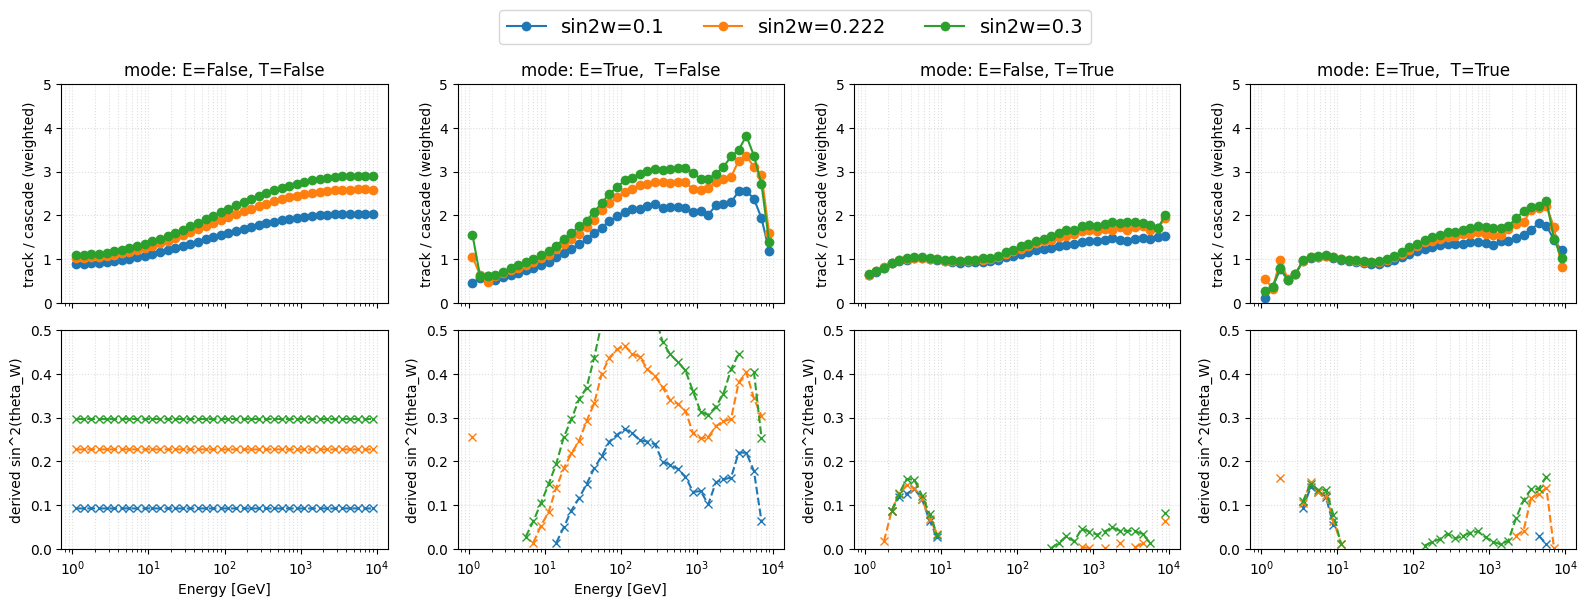

Some doubts about Track_mu resampling, but could be due to the GNN just being bad...


In [38]:

# Plot: rows = modes, cols = 2 (left: track/cascade, right: sin^2(theta_W))
mode_labels = {
    (False, False): 'E=False, T=False',
    (True,  False): 'E=True,  T=False',
    (False, True):  'E=False, T=True',
    (True,  True):  'E=True,  T=True',
}

# Color by sin2w hypothesis for clearer comparison within each mode
colors_by_s = {0.1:'tab:blue', 0.222:'tab:orange', 0.30:'tab:green'}

nrows = len(modes)
fig, axes = plt.subplots(2, nrows, figsize=(4*nrows, 6), sharex='col')
if nrows == 1:
    axes = np.array([axes])

for r, mode in enumerate(modes):
    resE, resT = mode
    ax_left = axes[0, r]
    ax_right = axes[1, r]
    sub_m = plot_df[(plot_df['resample_E'] == resE) & (plot_df['resample_T'] == resT)]
    for s in sin2w_grid:
        sub_s = sub_m[sub_m['sin2w'] == s].sort_values('E_center')
        Evals = sub_s['E_center'].to_numpy()
        tc = sub_s['track_over_cascade'].to_numpy()
        s2 = sub_s['sin2theta'].to_numpy()
        ax_left.plot(Evals, tc, marker='o', label=f'sin2w={s}', color=colors_by_s[s])
        ax_right.plot(Evals, s2, marker='x', linestyle='--', label=f'sin2w={s}', color=colors_by_s[s])

    ax_left.set_xscale('log')
    ax_left.grid(True, which='both', ls=':', alpha=0.4)
    ax_left.set_ylabel('track / cascade (weighted)')
    ax_left.set_title(f'mode: {mode_labels[mode]}')
    ax_left.set_ylim(0, 5)

    ax_right.set_xscale('log')
    ax_right.set_ylim(0, 0.5)
    ax_right.grid(True, which='both', ls=':', alpha=0.4)
    ax_right.set_ylabel('derived sin^2(theta_W)')

axes[-1, 0].set_xlabel('Energy [GeV]')
axes[-1, 1].set_xlabel('Energy [GeV]')

# One legend at the top for sin2w series
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=min(len(labels), 6), fontsize=14, bbox_to_anchor=(0.5, 1.02))

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

print('Some doubts about Track_mu resampling, but could be due to the GNN just being bad...')

Low-energy subset (energy in [0.0, 50.0] GeV) size: 2872516


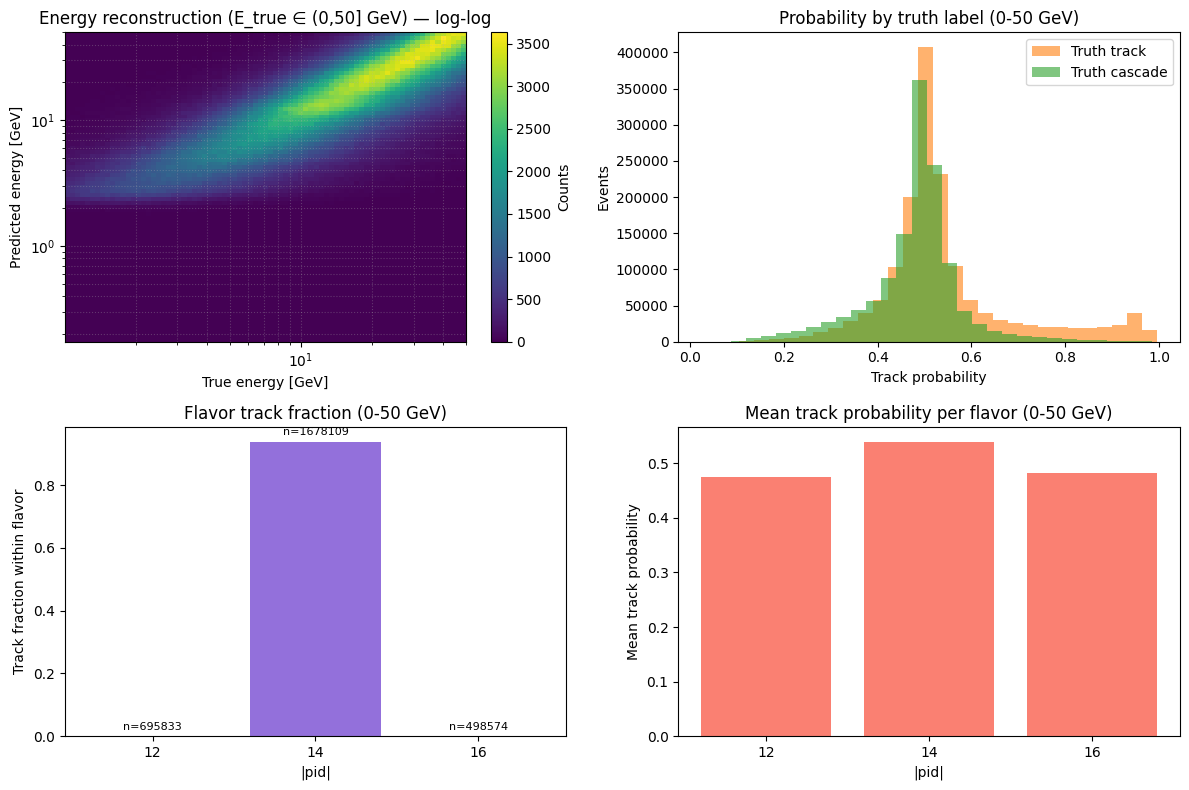

,E_low,E_high,total,track,track_fraction,mean_prob
0,0.0,5.0,501049,315385,0.629449,0.508278
1,5.0,10.0,550597,326157,0.592370,0.509524
2,10.0,15.0,419556,233584,0.556741,0.511495
3,15.0,20.0,326060,173313,0.531537,0.514895
4,20.0,25.0,260973,133422,0.511248,0.517628
5,25.0,30.0,216516,107665,0.497261,0.518662
6,30.0,35.0,183272,89360,0.487581,0.520526
7,35.0,40.0,157913,75863,0.480410,0.520389
8,40.0,45.0,136349,64877,0.475816,0.521146
9,45.0,50.0,120231,56238,0.467750,0.521016


Note: track_fraction is conditional within each energy bin; mean_prob is average model track probability.
At low energy all events are basically 50/50, meaning not only the muon neutrinos, but also the electron neutrinos. and at low energy theres a lot more electron neutrinos than at higher energies, so this explains why at low energy the prediction is so different from the truth


In [39]:
# Low-energy (0-50 GeV) plots: energy reconstruction (top-left) + probability/flavor histograms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

LOW_E_EXT_MIN = 0.0
LOW_E_EXT_MAX = 50.0

if 'db_MC_neutrinos_cut' not in globals():
    print('Dataset db_MC_neutrinos_cut not loaded.')
else:
    df_le = db_MC_neutrinos_cut[(db_MC_neutrinos_cut['energy'] >= LOW_E_EXT_MIN) & (db_MC_neutrinos_cut['energy'] <= LOW_E_EXT_MAX)]
    n_le = len(df_le)
    print(f'Low-energy subset (energy in [{LOW_E_EXT_MIN}, {LOW_E_EXT_MAX}] GeV) size: {n_le}')

    # Determine probability column (for other panels)
    prob_col = None
    for c in ['track_mu_pred','track_mu_prob','prob_track','prob']:
        if c in df_le.columns:
            prob_col = c
            break

    # Prepare 2x2 figure
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    ax_tl = axes[0,0]   # top-left: energy reconstruction 2D hist
    ax_tr = axes[0,1]   # top-right: prob by truth
    ax_bl = axes[1,0]   # bottom-left: track fraction per flavor
    ax_br = axes[1,1]   # bottom-right: mean prob per flavor

    # 1. Top-left: Energy reconstruction 2D histogram (x=true, y=pred) — log-log
    if {'energy','energy_pred'}.issubset(df_le.columns):
        x_true = pd.to_numeric(df_le['energy'], errors='coerce').to_numpy()
        y_pred = pd.to_numeric(df_le['energy_pred'], errors='coerce').to_numpy()
        m = np.isfinite(x_true) & np.isfinite(y_pred) & (x_true > 0) & (y_pred > 0)
        x_true, y_pred = x_true[m], y_pred[m]
        if x_true.size == 0:
            ax_tl.text(0.5, 0.5, 'No positive events in (0,50] GeV', ha='center')
            ax_tl.set_axis_off()
        else:
            # Define log-spaced bins: x in (min_pos_x, 50], y in (min_pos_y, 50]
            min_pos_x = max(1e-2, float(np.nanmin(x_true[x_true > 0])))
            min_pos_y = max(1e-2, float(np.nanmin(y_pred[y_pred > 0])))
            xbins = np.logspace(np.log10(min_pos_x), np.log10(LOW_E_EXT_MAX), 80)
            ybins = np.logspace(np.log10(min_pos_y), np.log10(LOW_E_EXT_MAX), 80)
            h = ax_tl.hist2d(x_true, y_pred, bins=[xbins, ybins], cmap='viridis')
            cb = plt.colorbar(h[3], ax=ax_tl, label='Counts')
            ax_tl.set_xscale('log')
            ax_tl.set_yscale('log')
            ax_tl.set_xlim(min_pos_x, LOW_E_EXT_MAX)
            ax_tl.set_ylim(min_pos_y, LOW_E_EXT_MAX)
            ax_tl.set_xlabel('True energy [GeV]')
            ax_tl.set_ylabel('Predicted energy [GeV]')
            ax_tl.set_title('Energy reconstruction (E_true ∈ (0,50] GeV) — log-log')
            ax_tl.grid(True, which='both', ls=':', alpha=0.3)
    else:
        ax_tl.text(0.5, 0.5, 'energy/energy_pred not available', ha='center')
        ax_tl.set_axis_off()

    # For probability-based panels, only proceed if prob_col exists
    if prob_col is None:
        print('No probability column found among candidates for probability-based panels.')
        # Clear remaining axes to avoid confusion
        ax_tr.text(0.5,0.5,'No prob column', ha='center')
        ax_tr.set_axis_off()
        ax_bl.text(0.5,0.5,'No prob column', ha='center')
        ax_bl.set_axis_off()
        ax_br.text(0.5,0.5,'No prob column', ha='center')
        ax_br.set_axis_off()
        plt.tight_layout()
        plt.show()
    else:
        probs_le = pd.to_numeric(df_le[prob_col], errors='coerce').to_numpy()
        # Truth track flag
        if 'track_mu' in df_le.columns:
            track_truth_le = df_le['track_mu'].to_numpy()
        else:
            track_truth_le = (probs_le > 0.5).astype(int)  # fallback heuristic

        # 2. Top-right: Probability split by truth track/cascade
        mask_t = (track_truth_le == 1)
        mask_c = (track_truth_le == 0)
        if mask_t.any():
            ax_tr.hist(probs_le[mask_t], bins=30, alpha=0.6, label='Truth track', color='tab:orange')
        if mask_c.any():
            ax_tr.hist(probs_le[mask_c], bins=30, alpha=0.6, label='Truth cascade', color='tab:green')
        ax_tr.set_xlabel('Track probability')
        ax_tr.set_ylabel('Events')
        ax_tr.set_title('Probability by truth label (0-50 GeV)')
        ax_tr.legend()

        # 3. Bottom-left: Track fraction per flavor in this energy window
        if 'pid' in df_le.columns:
            abs_pid_le = df_le['pid'].abs()
            unique_pids = sorted(abs_pid_le.unique())
            track_frac_pid = []
            counts_pid = []
            for pid_abs in unique_pids:
                mask_pid = (abs_pid_le == pid_abs)
                total_pid = int(mask_pid.sum())
                track_pid = int((track_truth_le[mask_pid] == 1).sum())
                frac = track_pid / total_pid if total_pid > 0 else np.nan
                track_frac_pid.append(frac)
                counts_pid.append(total_pid)
            ax_bl.bar([str(p) for p in unique_pids], track_frac_pid, color='mediumpurple')
            ax_bl.set_ylabel('Track fraction within flavor')
            ax_bl.set_xlabel('|pid|')
            ax_bl.set_title('Flavor track fraction (0-50 GeV)')
            for i, (p, c) in enumerate(zip(unique_pids, counts_pid)):
                if np.isfinite(track_frac_pid[i]):
                    ax_bl.text(i, track_frac_pid[i]+0.02, f'n={c}', ha='center', fontsize=8)
        else:
            ax_bl.text(0.5,0.5,'pid column missing', ha='center')
            ax_bl.set_axis_off()

        # 4. Bottom-right: Mean probability per flavor
        if 'pid' in df_le.columns and prob_col is not None:
            mean_prob_pid = []
            for pid_abs in unique_pids:
                mask_pid = (abs_pid_le == pid_abs)
                mean_prob_pid.append(np.nanmean(probs_le[mask_pid]) if mask_pid.any() else np.nan)
            ax_br.bar([str(p) for p in unique_pids], mean_prob_pid, color='salmon')
            ax_br.set_ylabel('Mean track probability')
            ax_br.set_xlabel('|pid|')
            ax_br.set_title('Mean track probability per flavor (0-50 GeV)')
        else:
            ax_br.text(0.5,0.5,'pid/prob missing', ha='center')
            ax_br.set_axis_off()

        plt.tight_layout()
        plt.show()

        # 5. Binned (5 GeV) counts & track fraction table (unchanged)
        bin_edges_le = np.arange(LOW_E_EXT_MIN, LOW_E_EXT_MAX + 5, 5)
        rows = []
        for lo, hi in zip(bin_edges_le[:-1], bin_edges_le[1:]):
            m = (df_le['energy'] >= lo) & (df_le['energy'] < hi)
            total_bin = int(m.sum())
            if total_bin == 0:
                rows.append({'E_low': lo, 'E_high': hi, 'total': 0, 'track': 0, 'track_fraction': np.nan, 'mean_prob': np.nan})
                continue
            track_bin = int((track_truth_le[m] == 1).sum())
            mean_prob_bin = float(np.nanmean(probs_le[m]))
            rows.append({'E_low': lo, 'E_high': hi, 'total': total_bin, 'track': track_bin, 'track_fraction': track_bin/total_bin, 'mean_prob': mean_prob_bin})
        le_table = pd.DataFrame(rows)
        display(le_table)
        print('Note: track_fraction is conditional within each energy bin; mean_prob is average model track probability.')

print('At low energy all events are basically 50/50, meaning not only the muon neutrinos, but also the electron neutrinos. and at low energy theres a lot more electron neutrinos than at higher energies, so this explains why at low energy the prediction is so different from the truth')

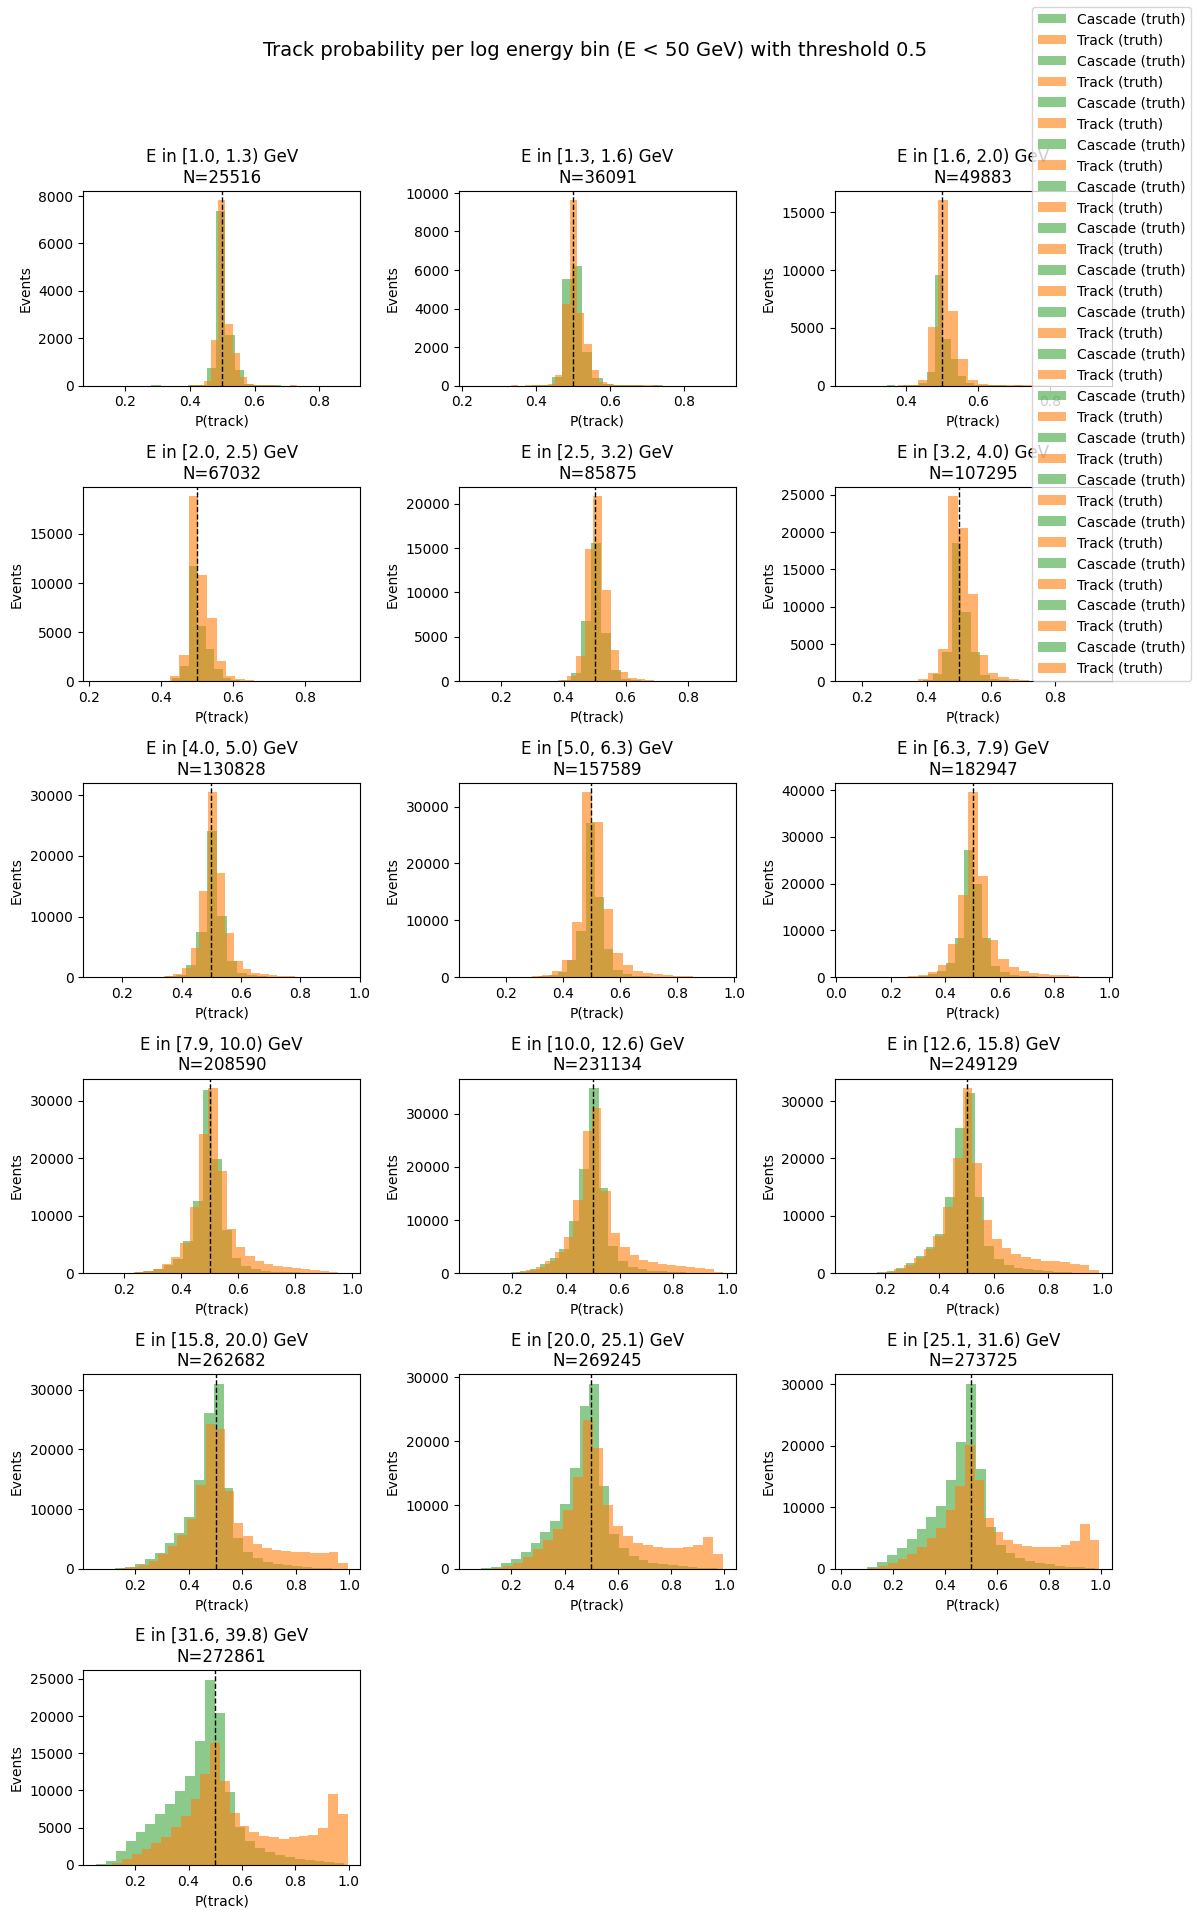

,E_low,E_high,N,track_frac_truth,mean_prob,pred_track,pred_cascade,pred_ratio
0,1.000000,1.258925,25516,0.566390,0.504373,10106,15410,0.655808
1,1.258925,1.584893,36091,0.599595,0.505466,15370,20721,0.741760
2,1.584893,1.995262,49883,0.626065,0.506886,22759,27124,0.839072
3,1.995262,2.511886,67032,0.635860,0.508045,32515,34517,0.942000
4,2.511886,3.162278,85875,0.642620,0.508768,43215,42660,1.013010
5,3.162278,3.981072,107295,0.641670,0.509206,55012,52283,1.052197
6,3.981072,5.011872,130828,0.629269,0.509398,67581,63247,1.068525
7,5.011872,6.309573,157589,0.608653,0.509219,81081,76508,1.059772
8,6.309573,7.943282,182947,0.594905,0.509234,92967,89980,1.033196
9,7.943282,10.000000,208590,0.577616,0.510009,104324,104266,1.000556


Columns: track_frac_truth = truth track fraction in bin; mean_prob = average predicted track probability; pred_track/pred_cascade = counts using threshold 0.5; pred_ratio = pred_track/pred_cascade.


In [40]:
# Track probability histograms per log energy bin (bins with upper edge < 50 GeV)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Identify bin edges source
_edges = None
if 'log_binedges' in globals():
    _edges = np.asarray(log_binedges, dtype=float)
elif 'bin_edges' in globals():
    _edges = np.asarray(bin_edges, dtype=float)
else:
    print('No log_binedges or bin_edges found; aborting per-bin histograms.')

if _edges is not None:
    if 'db_MC_neutrinos_cut' not in globals() or 'energy' not in db_MC_neutrinos_cut.columns:
        print('Energy data not available for per-bin histograms.')
    else:
        df_all = db_MC_neutrinos_cut
        # Determine probability column
        prob_col = None
        for c in ['track_mu_pred','track_mu_prob','prob_track','prob']:
            if c in df_all.columns:
                prob_col = c
                break
        if prob_col is None:
            print('No probability column found among candidates; aborting.')
        else:
            probs_all = df_all[prob_col].values
            if 'track_mu' in df_all.columns:
                track_truth_all = df_all['track_mu'].values
            else:
                track_truth_all = (probs_all > 0.5).astype(int)
            # Predicted (threshold 0.5)
            track_pred_all = (probs_all >= 0.5).astype(int)

            bin_pairs = list(zip(_edges[:-1], _edges[1:]))
            sel_pairs = [(lo, hi) for lo, hi in bin_pairs if hi <= 50.0]
            n_sel = len(sel_pairs)
            if n_sel == 0:
                print('No log energy bins with upper edge < 50 GeV.')
            else:
                n_cols = 3
                n_rows = int(np.ceil(n_sel / n_cols))
                fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3.2*n_rows), squeeze=False)
                axes_flat = axes.flatten()

                for i, (lo, hi) in enumerate(sel_pairs):
                    ax = axes_flat[i]
                    mask_bin = (df_all['energy'] >= lo) & (df_all['energy'] < hi)
                    probs_bin = probs_all[mask_bin]
                    if probs_bin.size == 0:
                        ax.text(0.5, 0.5, f'Empty\n[{lo:.2f},{hi:.2f})', ha='center')
                        ax.set_axis_off()
                        continue
                    if 'track_mu' in df_all.columns:
                        tt_bin = track_truth_all[mask_bin]
                        # Plot truth cascade first so track overlays clearly
                        if (tt_bin==0).any():
                            ax.hist(probs_bin[tt_bin==0], bins=25, color='tab:green', alpha=0.55, label='Cascade (truth)')
                        if (tt_bin==1).any():
                            ax.hist(probs_bin[tt_bin==1], bins=25, color='tab:orange', alpha=0.60, label='Track (truth)')
                    else:
                        # If no truth labels available, show distribution only
                        ax.hist(probs_bin, bins=25, color='steelblue', alpha=0.75)
                    # Threshold line at 0.5
                    ax.axvline(0.5, color='black', linestyle='--', linewidth=1.0)
                    ax.set_title(f'E in [{lo:.1f}, {hi:.1f}) GeV\nN={probs_bin.size}')
                    ax.set_xlabel('P(track)')
                    ax.set_ylabel('Events')

                # Remove unused axes
                for j in range(i+1, len(axes_flat)):
                    axes_flat[j].set_axis_off()

                if 'track_mu' in df_all.columns:
                    fig.legend(loc='upper right')
                fig.suptitle('Track probability per log energy bin (E < 50 GeV) with threshold 0.5', fontsize=14)
                plt.tight_layout(rect=[0,0,0.95,0.95])
                plt.show()

                # Summary table
                rows = []
                for lo, hi in sel_pairs:
                    m = (df_all['energy'] >= lo) & (df_all['energy'] < hi)
                    total = m.sum()
                    if total == 0:
                        rows.append({'E_low': lo, 'E_high': hi, 'N': 0, 'track_frac_truth': np.nan, 'mean_prob': np.nan, 'pred_track': 0, 'pred_cascade': 0, 'pred_ratio': np.nan})
                        continue
                    tt = track_truth_all[m]
                    probs_bin_all = probs_all[m]
                    pred_flags = track_pred_all[m]
                    track_count_truth = (tt==1).sum()
                    track_count_pred = pred_flags.sum()
                    casc_count_pred = total - track_count_pred
                    pred_ratio = track_count_pred / casc_count_pred if casc_count_pred > 0 else np.nan
                    rows.append({
                        'E_low': lo,
                        'E_high': hi,
                        'N': total,
                        'track_frac_truth': track_count_truth/total,
                        'mean_prob': probs_bin_all.mean(),
                        'pred_track': track_count_pred,
                        'pred_cascade': casc_count_pred,
                        'pred_ratio': pred_ratio
                    })
                per_log_low = pd.DataFrame(rows)
                display(per_log_low)
                print("Columns: track_frac_truth = truth track fraction in bin; mean_prob = average predicted track probability; pred_track/pred_cascade = counts using threshold 0.5; pred_ratio = pred_track/pred_cascade.")

In [41]:
# Final cell: load burn CSV, compute resampled (resample_E=True,resample_T=True) and plot vs burn predictions
burn_path = '/groups/icecube/nielsdb/GNN_ET/inference/191125p0_211125_231125.csv'
burn_csv = pd.read_csv(burn_path)
print('Loaded burn_csv:', burn_csv.shape)
print('Columns:', list(burn_csv.columns))



Loaded burn_csv: (10000, 4)
Columns: ['event_no', 'energy_pred', 'track_mu_pred', 'logit']


In [42]:
# Compute track / cascade per energy bin from burn CSV (using track_mu_pred)
import numpy as np
import pandas as pd

burn_path = '/groups/icecube/nielsdb/GNN_ET/inference/191125p0_211125_231125.csv'
burn_csv = pd.read_csv(burn_path)
print('Loaded burn_csv:', burn_csv.shape)

# Load flux to get energy bin centers and reconstruct bin edges (same logic as earlier cells)
flux_path = '/groups/icecube/nielsdb/SinTheta_Aug2025/mceq_zenith_averaged_fluxes.csv'
flux = pd.read_csv(flux_path)
bin_centers = np.asarray(flux['Energy_GeV'].values, dtype=float)
# compute log-spaced bin edges consistent with notebook
bin_edges_mid = np.sqrt(bin_centers[:-1] * bin_centers[1:])
left_edge = bin_centers[0] * (bin_centers[1]/bin_centers[0])**-0.5
right_edge = bin_centers[-1] * (bin_centers[-1]/bin_centers[-2])**0.5
bin_edges = np.concatenate(([left_edge], bin_edges_mid, [right_edge]))

# Map burn predictions (energy_pred) into these energy bins and compute predicted track/cascade counts
energy_pred = np.asarray(burn_csv['energy_pred'].to_numpy(dtype=float), dtype=float)
track_pred = np.asarray(burn_csv['track_mu_pred'].to_numpy(dtype=float), dtype=float)
idx = np.digitize(energy_pred, bin_edges) - 1
n_bins = len(bin_centers)
rows = []
for i in range(n_bins):
    sel = (idx == i)
    n_sel = int(np.sum(sel))
    if n_sel == 0:
        rows.append({'E_center': float(bin_centers[i]), 'n_events': 0, 'n_tracks': 0, 'n_casc': 0, 'track_over_cascade': float('nan')})
        continue
    tracks = int(np.sum(track_pred[sel] > 0.5))
    cascs = int(np.sum(track_pred[sel] <= 0.5))
    ratio = (tracks / cascs) if cascs > 0 else float('nan')
    rows.append({'E_center': float(bin_centers[i]), 'n_events': n_sel, 'n_tracks': tracks, 'n_casc': cascs, 'track_over_cascade': float(ratio)})


df_burn_tc = pd.DataFrame(rows)
print(df_burn_tc.to_string(index=False))
# Save per-bin results for later use

print(df_burn_tc['track_over_cascade'])

Loaded burn_csv: (10000, 4)
   E_center  n_events  n_tracks  n_casc  track_over_cascade
   1.122018         0         0       0                 NaN
   1.412538         0         0       0                 NaN
   1.778279         0         0       0                 NaN
   2.238721         2         2       0                 NaN
   2.818383        12         5       7            0.714286
   3.548134        36        28       8            3.500000
   4.466836        96        70      26            2.692308
   5.623413       182       100      82            1.219512
   7.079458       251       117     134            0.873134
   8.912509       335       151     184            0.820652
  11.220185       324       132     192            0.687500
  14.125375       359       175     184            0.951087
  17.782794       311       169     142            1.190141
  22.387211       340       171     169            1.011834
  28.183829       322       191     131            1.458015
  35.481339 

In [43]:
# 4x2 grid: rows = four modes, cols = [track/cascade, derived sin^2(theta_W)]
# Each subplot shows curves for all sin2w values in sin2w_grid

# Ensure sin2w_grid exists (fallback if earlier cell not run)
sin2w_grid = [0.1, 0.222, 0.30]

# Helper to compute weighted track/cascade ratio per energy bin given resampler output
def _compute_track_over_cascade(res, threshold=0.5):
    e_edges = res['energy_edges']
    e_centers = res['energy_centers']
    tracks = res['events']['track']
    energies = res['events']['energy']
    w_events = res['event_weights']
    ebin = np.digitize(energies, e_edges) - 1
    out_rows = []
    for i, E in enumerate(e_centers):
        sel = (ebin == i)
        if not np.any(sel):
            out_rows.append({'E_center': float(E), 'track_over_cascade': np.nan})
            continue
        tvals = tracks[sel]
        wvals = w_events[sel]
        is_track = (tvals > threshold)
        track_w = float(np.sum(wvals[is_track]))
        casc_w = float(np.sum(wvals[~is_track]))
        ratio = (track_w / casc_w) if casc_w > 0 else np.nan
        out_rows.append({'E_center': float(E), 'track_over_cascade': ratio})
    return out_rows

# Precompute alpha(E) grid from flux for consistent interpolation
E_flux = np.asarray(log_bincenters, dtype=float)
print(flux.columns)
alpha_flux = (flux['numu_total_flux']) / (flux['nue_total_flux'] + flux['numu_total_flux'])  # no tau
alpha_flux = np.asarray(alpha_flux, dtype=float)

# Build results for requested modes and sin2w grid
rows = []
print('[4x2 plots] Computing track/cascade and derived sin^2(theta_W) for all modes and sin2w_grid...')
print(f'Doing resE:{True}, resT:{True}')
for s in sin2w_grid:
    print(f'Doing sin2theta:{s}')
    # NC scaling factor for this hypothesis
    _, R_scale = scale_sigma_NC(np.array([1.0]), s)
    res = resample_predictions_per_true_bin_optimized(
        db_MC_neutrinos_cut,
        bin_summary_df,
        R=R_scale,
        resample_E=True,
        resample_T=True,
        n_energy_bins=40,
        n_track_bins=40,
        return_events=True,
    )
    per_bin = _compute_track_over_cascade(res, threshold=0.5)
    # Energy centers for this result and corresponding alpha(E)
    Evals = np.array([r['E_center'] for r in per_bin], dtype=float)
    alpha_vals = np.interp(np.log10(Evals), np.log10(E_flux), alpha_flux, left=alpha_flux[0], right=alpha_flux[-1])
    # Convert track/cascade -> NC/CC -> sin^2(theta_W) using helper function
    tc_vals = np.array([r['track_over_cascade'] for r in per_bin], dtype=float)
    nccc_vals = get_nccc_from_tc(tc_vals, alpha=alpha_vals)
    s2_vals = np.array([get_s2t_from_nccc(x) for x in nccc_vals])
    for (E, tc, s2) in zip(Evals, tc_vals, s2_vals):
        rows.append({
            'resample_E': resE,
            'resample_T': resT,
            'sin2w': float(s),
            'E_center': float(E),
            'track_over_cascade': float(tc) if np.isfinite(tc) else np.nan,
            'sin2theta': float(s2) if np.isfinite(s2) else np.nan,
        })
plot_df = pd.DataFrame(rows)
print(f"[4x2 plots] Data ready. Shape={plot_df.shape}")

Index(['Energy_GeV', 'numu_total_flux', 'nue_total_flux', 'nutau_total_flux'], dtype='object')
[4x2 plots] Computing track/cascade and derived sin^2(theta_W) for all modes and sin2w_grid...
Doing resE:True, resT:True
Doing sin2theta:0.1
Doing sin2theta:0.222
Doing sin2theta:0.3
[4x2 plots] Data ready. Shape=(120, 6)


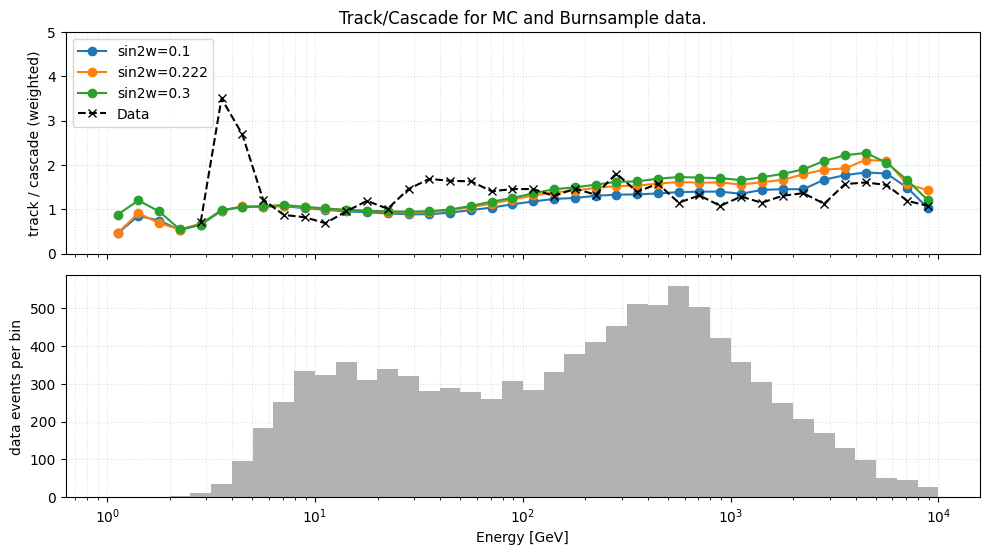

In [44]:
# Color by sin2w hypothesis for clearer comparison within each mode
colors_by_s = {0.1:'tab:blue', 0.222:'tab:orange', 0.30:'tab:green'}

fig, axes = plt.subplots(2, 1, sharex='col', figsize=(10,6))
if nrows == 1:
    axes = np.array([axes])

ax_left = axes[0]
ax_right = axes[1]
sub_m = plot_df[(plot_df['resample_E'] == resE) & (plot_df['resample_T'] == resT)]
for s in sin2w_grid:
    sub_s = sub_m[sub_m['sin2w'] == s].sort_values('E_center')
    Evals = sub_s['E_center'].to_numpy()
    tc = sub_s['track_over_cascade'].to_numpy()
    ax_left.plot(Evals, tc, marker='o', label=f'sin2w={s}', color=colors_by_s[s])

ax_left.set_xscale('log')
ax_left.grid(True, which='both', ls=':', alpha=0.4)
ax_left.set_ylabel('track / cascade (weighted)')
ax_left.set_title(f'Track/Cascade for MC and Burnsample data.')
ax_left.set_ylim(0, 5)
ax_left.plot(df_burn_tc['E_center'], df_burn_tc['track_over_cascade'], marker='x', linestyle='--', color='black', label='Data')

# Burn prediction counts: use log-spaced bin widths so bars look uniform on log axis
Ecent = np.asarray(df_burn_tc['E_center'].to_numpy(), dtype=float)
counts = df_burn_tc['n_events'].to_numpy()
ax_right.set_xscale('log')
if Ecent.size > 1:
    # Reconstruct edges for geometric (log) spacing
    edges_mid = np.sqrt(Ecent[:-1] * Ecent[1:])
    left_edge = Ecent[0] * (Ecent[1] / Ecent[0]) ** -0.5
    right_edge = Ecent[-1] * (Ecent[-1] / Ecent[-2]) ** 0.5
    edges = np.concatenate(([left_edge], edges_mid, [right_edge]))
    widths = edges[1:] - edges[:-1]
    # Align bars to left edge of each bin for exact coverage
    ax_right.bar(edges[:-1], counts, width=widths, align='edge', color='gray', alpha=0.6)
else:
    ax_right.bar(Ecent, counts, width=0.8, color='gray', alpha=0.6)

ax_right.set_ylabel('data events per bin')
ax_right.grid(True, which='both', ls=':', alpha=0.4)

ax_right.set_xlabel('Energy [GeV]')
# One legend at the top for sin2w series
ax_left.legend(loc='upper left')

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

Best-fit sin^2(theta_W) ~ 0.0844 with chi^2 = 12.487


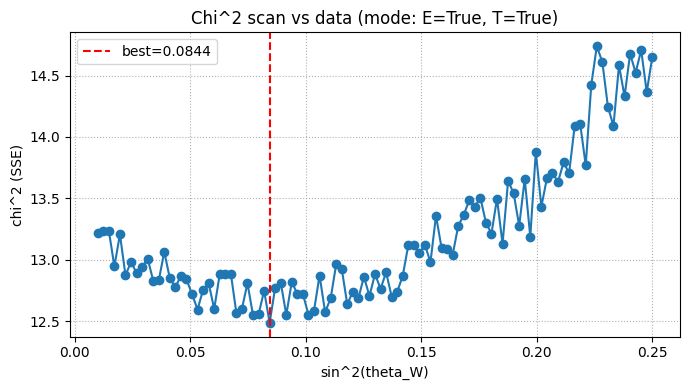

In [45]:
# Chi^2 scan: sin^2(theta_W) vs data track/cascade (mode: resample_E=True, resample_T=True)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Input grid of sin^2(theta_W)
# Feel free to adjust the range/spacing
sin2w_scan = np.linspace(0.01, 0.25, 101)

# 2) Build the data "line" (track/cascade per energy bin)
# Priority: use df_burn_tc if it exists and has the needed columns.
# Fallback: compute per-bin track/cascade from burn_csv using `bin_edges` and a probability/track column.

def _build_data_line():
    # Preferred: use existing df_burn_tc
    if 'df_burn_tc' in globals():
        df = df_burn_tc.copy()
        if {'E_center','track_over_cascade'}.issubset(df.columns):
            df = df[['E_center','track_over_cascade']].dropna()
            # Only keep positive E_center
            df = df[np.isfinite(df['E_center']) & (df['E_center'] > 0)]
            return df.reset_index(drop=True)
    # Fallback from burn_csv
    if 'burn_csv' in globals():
        dfb = burn_csv.copy()
        # Find probability or track indicator
        track_flag = None
        prob_col = None
        for c in ['track_mu_pred','track_pred','is_track','track_flag']:
            if c in dfb.columns:
                track_flag = (pd.to_numeric(dfb[c], errors='coerce') >= 0.5).astype(int).to_numpy()
                break
        if track_flag is None:
            for c in ['track_mu_prob','prob_track','prob']:
                if c in dfb.columns:
                    prob_col = c
                    break
            if prob_col is None:
                print("No track flag or probability column found in burn_csv; cannot build data line.")
                return None
            track_flag = (pd.to_numeric(dfb[prob_col], errors='coerce') >= 0.5).astype(int).to_numpy()
        # Energy for binning: use predicted energy if available
        if 'energy_pred' not in dfb.columns:
            print("burn_csv missing 'energy_pred'; cannot bin data by energy.")
            return None
        e = pd.to_numeric(dfb['energy_pred'], errors='coerce').to_numpy()
        m = np.isfinite(e)
        e = e[m]
        tflag = track_flag[m]
        # Bin edges
        if 'bin_edges' not in globals():
            print("Global 'bin_edges' not found; cannot bin data by energy."
                  " Ensure flux->bin_edges cell ran before this.")
            return None
        edges = np.asarray(bin_edges, dtype=float)
        centers = np.sqrt(edges[:-1] * edges[1:])
        idx = np.digitize(e, edges) - 1
        rows = []
        for i in range(len(edges)-1):
            mbin = (idx == i)
            n_tot = int(np.sum(mbin))
            if n_tot == 0:
                continue
            n_track = int(np.sum(tflag[mbin] == 1))
            n_casc = n_tot - n_track
            ratio = (n_track / n_casc) if n_casc > 0 else np.nan
            rows.append({'E_center': float(centers[i]), 'track_over_cascade': ratio, 'n_track': n_track, 'n_casc': n_casc})
        df = pd.DataFrame(rows)
        df = df[np.isfinite(df['track_over_cascade'])]
        return df.reset_index(drop=True)
    print("burn_csv not available; cannot build data line.")
    return None

_data_line = _build_data_line()
if _data_line is None or _data_line.empty:
    raise RuntimeError("Data line could not be constructed. Please ensure df_burn_tc or burn_csv+bin_edges are available.")

# 3) Helper: compute model track/cascade per energy bin for given sin2w (mode True,True)
# Requires these globals previously defined: db_MC_neutrinos_cut, bin_summary_df, scale_sigma_NC,
# resample_predictions_per_true_bin_optimized, and _compute_track_over_cascade.

def _model_tc_for_sin2w(sin2w, threshold=0.5):
    # NC scaling factor for this hypothesis
    _, R_scale = scale_sigma_NC(np.array([1.0]), sin2w)
    res = resample_predictions_per_true_bin_optimized(
        db_MC_neutrinos_cut,
        bin_summary_df,
        R=R_scale,
        resample_E=True,
        resample_T=True,
        n_energy_bins=40,
        n_track_bins=40,
        return_events=True,
    )
    per_bin = _compute_track_over_cascade(res, threshold=threshold)
    df = pd.DataFrame(per_bin)
    if not {'E_center','track_over_cascade'}.issubset(df.columns):
        raise RuntimeError("Model result missing required columns E_center / track_over_cascade")
    df = df[['E_center','track_over_cascade']].copy()
    df = df[np.isfinite(df['E_center']) & (df['E_center'] > 0)]
    return df.reset_index(drop=True)

# 4) Chi^2 computation: align data and model by energy center (log-scale interpolation by default)

EPS = 1e-12

def _chi2_model_vs_data(df_model, df_data):
    # Interpolate data to model E centers in log(E)
    x_m = df_model['E_center'].to_numpy()
    y_m = df_model['track_over_cascade'].to_numpy()
    x_d = df_data['E_center'].to_numpy()
    y_d = df_data['track_over_cascade'].to_numpy()

    # Ensure positive for log
    mask_m = np.isfinite(x_m) & np.isfinite(y_m) & (x_m > 0)
    mask_d = np.isfinite(x_d) & np.isfinite(y_d) & (x_d > 0)
    x_m, y_m = x_m[mask_m], y_m[mask_m]
    x_d, y_d = x_d[mask_d], y_d[mask_d]
    if x_m.size == 0 or x_d.size == 0:
        return np.nan

    y_d_interp = np.interp(np.log10(x_m), np.log10(x_d), y_d, left=np.nan, right=np.nan)
    mask = np.isfinite(y_m) & np.isfinite(y_d_interp)
    if not np.any(mask):
        return np.nan

    resid = y_m[mask] - y_d_interp[mask]

    # If data contains counts, estimate variance of ratio r=T/C as r^2*(1/T + 1/C);
    # else use unit variance (SSE) fallback.
    chi2 = None
    if {'n_track','n_casc'}.issubset(df_data.columns):
        # Build per-bin variances at interpolated points by nearest neighbor on log(E)
        # (simpler and robust vs extrapolation)
        idx_nn = np.searchsorted(np.log10(x_d), np.log10(x_m[mask]))
        idx_nn = np.clip(idx_nn, 0, len(x_d)-1)
        T = df_data['n_track'].to_numpy()[mask_d][idx_nn]
        C = df_data['n_casc'].to_numpy()[mask_d][idx_nn]
        # Avoid zeros
        T = np.maximum(T, 1.0)
        C = np.maximum(C, 1.0)
        r2 = (y_d_interp[mask]**2)
        var = r2 * (1.0/T + 1.0/C)
        var = np.where(np.isfinite(var) & (var > 0), var, 1.0)
        chi2 = float(np.sum((resid**2) / var))
    else:
        chi2 = float(np.sum(resid**2))
    return chi2

# 5) Scan and plot
chi2_vals = []
for s2 in sin2w_scan:
    try:
        df_model = _model_tc_for_sin2w(float(s2))
        chi2 = _chi2_model_vs_data(df_model, _data_line)
    except Exception as e:
        print(f"sin2w={s2:.4f} failed: {e}")
        chi2 = np.nan
    chi2_vals.append(chi2)

chi2_vals = np.array(chi2_vals, dtype=float)

# Report best-fit
mask_finite = np.isfinite(chi2_vals)
if not np.any(mask_finite):
    print("No finite chi^2 values computed.")
else:
    best_idx = int(np.nanargmin(chi2_vals))
    best_s2 = float(sin2w_scan[best_idx])
    best_chi2 = float(chi2_vals[best_idx])
    print(f"Best-fit sin^2(theta_W) ~ {best_s2:.4f} with chi^2 = {best_chi2:.3f}")

    # Plot
    plt.figure(figsize=(7,4))
    plt.plot(sin2w_scan, chi2_vals, marker='o', linestyle='-', color='tab:blue')
    plt.axvline(best_s2, color='red', linestyle='--', label=f'best={best_s2:.4f}')
    plt.xlabel('sin^2(theta_W)')
    plt.ylabel('chi^2' + (' (SSE)' if 'n_track' not in _data_line.columns else ''))
    plt.title('Chi^2 scan vs data (mode: E=True, T=True)')
    plt.grid(True, ls=':')
    plt.legend()
    plt.tight_layout()
    plt.show()

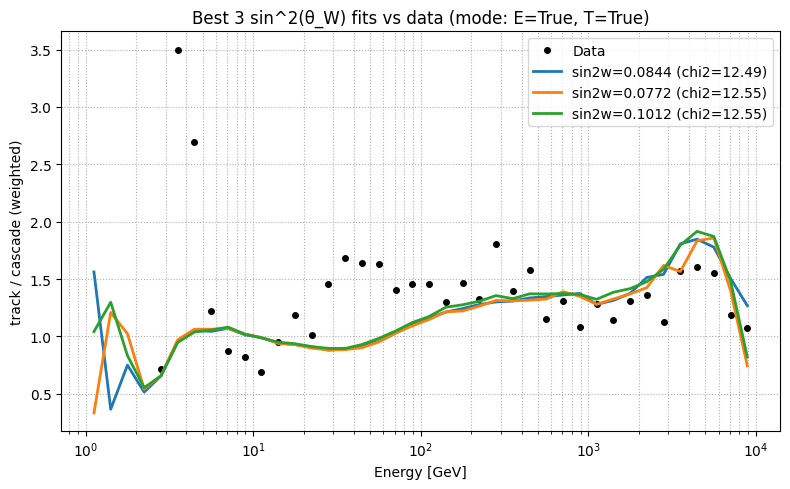

,s2,chi2
0,0.0844,12.486595
1,0.0772,12.547225
2,0.1012,12.551444


In [46]:
# Plot the best 3 sin^2(theta_W) fits against the data line
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Preconditions: requires sin2w_scan, chi2_vals, _data_line, and _model_tc_for_sin2w from previous cell
missing = []
for name in ['sin2w_scan','chi2_vals','_data_line','_model_tc_for_sin2w']:
    if name not in globals():
        missing.append(name)
if missing:
    raise RuntimeError(f"Missing required objects from previous cell: {missing}")

# Identify best 3 indices with finite chi2
chi2_arr = np.asarray(chi2_vals, dtype=float)
finite_idx = np.where(np.isfinite(chi2_arr))[0]
if finite_idx.size == 0:
    raise RuntimeError('No finite chi^2 values available to select best 3.')
order = finite_idx[np.argsort(chi2_arr[finite_idx])]
top_idx = order[:3]

best_entries = []
for i in top_idx:
    s2 = float(sin2w_scan[i])
    try:
        df_model = _model_tc_for_sin2w(s2)
        best_entries.append({'s2': s2, 'chi2': float(chi2_arr[i]), 'df': df_model})
    except Exception as e:
        print(f"Failed to build model curve for sin2w={s2:.5f}: {e}")

if not best_entries:
    raise RuntimeError('Could not compute any of the top-3 model curves.')

# Plot: data line + best 3 model curves
fig, ax = plt.subplots(figsize=(8,5))
# Data line as points
ax.plot(_data_line['E_center'], _data_line['track_over_cascade'], 'ko', ms=4, label='Data')

colors = ['tab:blue','tab:orange','tab:green']
for j, be in enumerate(best_entries):
    dfm = be['df']
    lbl = f"sin2w={be['s2']:.4f} (chi2={be['chi2']:.2f})"
    ax.plot(dfm['E_center'], dfm['track_over_cascade'], '-', lw=2, color=colors[j % len(colors)], label=lbl)

ax.set_xscale('log')
ax.set_xlabel('Energy [GeV]')
ax.set_ylabel('track / cascade (weighted)')
ax.set_title('Best 3 sin^2(θ_W) fits vs data (mode: E=True, T=True)')
ax.grid(True, which='both', ls=':')
ax.legend()
plt.tight_layout()
plt.show()

# Print a compact summary table of the top 3
summary = pd.DataFrame([{k:v for k,v in be.items() if k != 'df'} for be in best_entries])
display(summary.sort_values('chi2').reset_index(drop=True))